##Описание задачи

**Поиск товара на фотографии**


Товар может занимать только часть фотографии: обувь на ногах модели, серьги в ушах и.т.п На некоторых фотографиях вообще может не быть самого товара:


<img src ="https://ml.gan4x4.ru/wb/crop/content/29028922.jpg" width="200">


<img src ="https://ml.gan4x4.ru/wb/crop/content/18327379.jpg" width="200">


<img src ="https://ml.gan4x4.ru/wb/crop/content/42648846.jpg" width="200">


Для дальнейшего поиска похожих товаров важно локализовать товар на конкретном фото, т.е. предсказывать ограничивающий прямоугольник (bounding box) в который попадает  изображение товара и определить класс объекта в этом прямоугольнике.


В датасете 13 категорий товаров:

accessories (аксессуары/украшения)


* bag (сумка)
* belt (ремень)
* dress (платье)
* glasses (очки)
* headwear (то, что носят на голове, например головной убор или заколка)
* outer (верхняя одежда)
* pants (штаны)
* scarf (шарф)
* shoe (обувь)
* shorts (шорты)
* skirt (юбка)
* top (блузка, футболка, майка, кардиган и т.п)

Нужно предложть способ детектировать объекты этих классов на изображениях.
И оценить качество детектирования.

**Особенности разметки:**
* Некоторые изображения могут не содержать ни одного объекта
* Если объект виден частично, каждая его часть размечается отдельным bounding box
* несколько объектов одного класса находящихся рядом размечаются разными bounding box


##  Загрузка датасета

датасет содержащий изображения и разметку в [формате YOLO](https://stackoverflow.com/questions/56004483/what-is-a-multi-headed-model-and-what-exactly-is-a-head-in-a-model)

In [ ]:
!wget -nc https://ml.gan4x4.ru/wb/crop/clothes4/student.zip
!unzip student.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/97921615.jpg     
  inflating: images/87481692.jpg     
  inflating: images/87300377.jpg     
  inflating: images/73733150.jpg     
  inflating: images/40061418.jpg     
  inflating: images/28827190.jpg     
  inflating: images/10568131.jpg     
  inflating: images/98459149.jpg     
  inflating: images/80174631.jpg     
  inflating: images/72744065.jpg     
  inflating: images/72278222.jpg     
  inflating: images/68606473.jpg     
  inflating: images/15445740.jpg     
  inflating: images/149717823.jpg    
  inflating: images/48059211.jpg     
  inflating: images/46079230.jpg     
  inflating: images/35638079.jpg     
  inflating: images/35260709.jpg     
  inflating: images/33518377.jpg     
  inflating: images/29276838.jpg     
  inflating: images/29028922.jpg     
  inflating: images/26775325.jpg     
  inflating: images/25810083.jpg     
  inflating: images/24693885.jpg     
  inflating: images/

In [ ]:
!pip install tqdm --upgrade

In [ ]:
## importing required libraries
import os
import shutil
import random
from tqdm.notebook import tqdm
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [ ]:
#fixing seed
seed = 777
random.seed(seed)

In [ ]:
#read classes
with open("names.txt") as file:
    labels = [row.strip() for row in file]
print(len(labels),labels)

13 ['accessories', 'bag', 'belt', 'dress', 'glasses', 'headwear', 'outer', 'pants', 'scarf', 'shoe', 'shorts', 'skirt', 'top']


In [ ]:
# oruginal dataset init
dataImgPath = "./images/"
dataLabelsPath = "./labels/"

In [ ]:
# @title labels check (проверяется только соответствие каждой картинке txt файла с таким же названием)
filesImg = list(set([name[:-4] for name in os.listdir(dataImgPath)]))
filesLbl = list(set([name for name in os.listdir(dataLabelsPath)]))
notPaired = []
for filex in tqdm(filesImg):
  if not(filex+'.txt' in filesLbl):
    notPaired.append(filex)

if len(notPaired) == 0:
  print("\n","all images are labeled")
else:
  print("\n",len(notPaired)," images are not labeled:")
  print(notPaired)

  0%|          | 0/3968 [00:00<?, ?it/s]


 all images are labeled


## Анализ данных (EDA)

In [ ]:
print(labels)

['accessories', 'bag', 'belt', 'dress', 'glasses', 'headwear', 'outer', 'pants', 'scarf', 'shoe', 'shorts', 'skirt', 'top']


всего файлов:  3968
Class distribution:
top: 3187 objects
belt: 409 objects
accessories: 2411 objects
pants: 3463 objects
outer: 1392 objects
shoe: 2855 objects
shorts: 137 objects
bag: 590 objects
glasses: 308 objects
dress: 703 objects
headwear: 258 objects
scarf: 69 objects
skirt: 151 objects



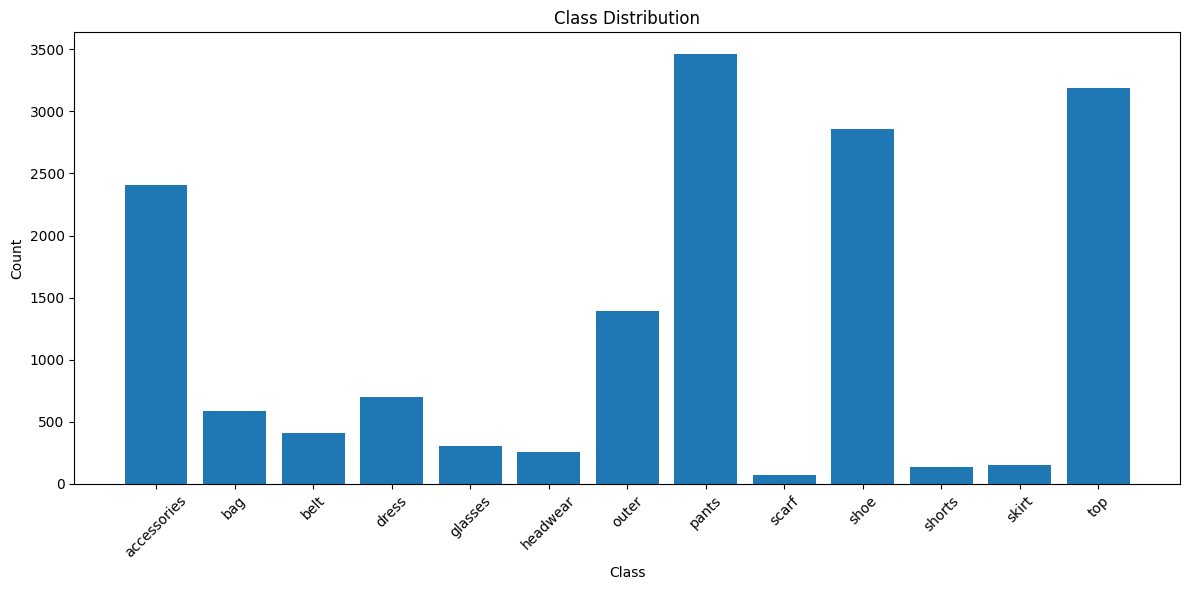

In [ ]:
## Анализ датасета изображений в формате YOLO

### Загрузка данных

images_dir = '/content/images'
labels_dir = '/content/labels'

image_files = os.listdir(images_dir)
label_files = os.listdir(labels_dir)
print("всего файлов: ",len(image_files))
### Анализ аннотаций

def read_yolo_annotations(label_file):
    annotations = []
    with open(label_file, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 5:
                class_id, x, y, width, height = map(float, values)
                annotations.append((int(class_id), x, y, width, height))
    return annotations

class_counts = Counter()
for label_file in label_files:
    annotations = read_yolo_annotations(os.path.join(labels_dir, label_file))
    for class_id, _, _, _, _ in annotations:
        class_counts[class_id] += 1

print("Class distribution:")
for class_id, count in class_counts.items():
    print(f"{labels[class_id]}: {count} objects")
print()

### Визуализация статистики по классам

class_ids = list(class_counts.keys())
class_counts_list = list(class_counts.values())

pairs = list(zip(class_ids, class_counts_list))
sorted_pairs = sorted(pairs)
sorted_indices, sorted_values = zip(*sorted_pairs)

class_ids = list(sorted_indices)
class_counts_list = list(sorted_values)

class_labels = [labels[class_id] for class_id in class_ids]

plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_counts_list)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

В данных содержится сильный дизбаланс классов. Без его устранения точность модели на редких классах будет очень низкой.

## Группировка данных

In [ ]:
# data path init
dataImgPath = "/content/images/"
dataLabelsPath = "/content/labels/"

In [ ]:
#train/val dir init
train_path_img = "./datasets/images/train/"
train_path_label = "./datasets/labels/train/"
val_path_img = "./datasets/images/val/"
val_path_label = "./datasets/labels/val/"

In [ ]:
'''
Split the dataset into train and test and creates the train.txt and test.tx with
the respective path of the images in each folder
'''

def train_test_split(pathImg, pathLabel,neg_path=None, split = 0.2):
    files = list(set([name[:-4] for name in os.listdir(pathImg)])) ## removing duplicate names i.e. counting only number of images

    print (f"--- This folder has a total number of {len(files)} images---")
    random.shuffle(files)

    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    ## creating required directories
    os.makedirs(train_path_img, exist_ok = True)
    os.makedirs(train_path_label, exist_ok = True)
    os.makedirs(val_path_img, exist_ok = True)
    os.makedirs(val_path_label, exist_ok = True)

    ### ----------- copying images to train folder
    for filex in tqdm(files[:train_size]):
      if filex == 'classes':
          continue
      shutil.copy2(pathImg + filex + '.jpg',f"{train_path_img}/" + filex + '.jpg' )
      shutil.copy2(pathLabel + filex + '.txt', f"{train_path_label}/" + filex + '.txt')

    print(f"\n------ Training data created with {1-split}% split {len(files[:train_size])} images -------")


    ### copytin images to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(pathImg + filex + '.jpg', f"{val_path_img}/" + filex + '.jpg' )
      shutil.copy2(pathLabel + filex + '.txt', f"{val_path_label}/" + filex + '.txt')
    print(f"\n------ Testing data created with a total of {len(files[train_size:])} images ----------")

In [ ]:
train_test_split(pathImg=dataImgPath,pathLabel=dataLabelsPath) #split data

--- This folder has a total number of 3321 images---


100%|██████████| 2657/2657 [00:06<00:00, 404.17it/s]



------ Training data created with 0.8% split 2657 images -------


100%|██████████| 664/664 [00:01<00:00, 625.96it/s]


------ Testing data created with a total of 664 images ----------


In [ ]:
#create yaml for dataset
with open("dataset.yaml", "w") as file:
    file.write("root: ./content/datasets" + "\n")
    file.write("train: images/train" + "\n")
    file.write("val: images/val" + "\n")
    file.write("train_path: ${root}/${train}" + "\n")
    file.write("val_path: ${root}/${val}" + "\n")

    file.write("nc: "+str(len(labels))+ "\n")
    file.write("names: "+str(labels))

dataYaml = '/content/dataset.yaml'

## Предобработка датасета

In [ ]:
# @title class dataframe

# Пути к исходному датасету
dataImgPath = "./images/"
dataLabelsPath = "./labels/"


# Создаем пустой DataFrame
data = []

# Считываем список файлов и их классы
files = os.listdir(dataImgPath)
for file in tqdm(files, desc="Обработка файлов", unit="файл"):
    label_file = Path(dataLabelsPath) / f"{os.path.splitext(file)[0]}.txt"
    if label_file.exists():
        with label_file.open("r") as f:
            labels_in_file = [int(line.split()[0]) for line in f.readlines()]
            class_counts = {label: 0 for label in labels}
            for label in labels_in_file:
                class_counts[labels[label]] += 1
        row = {"file": file, **class_counts}
        data.append(row)

# Создаем DataFrame
Datadf = pd.DataFrame(data)
Datadf = Datadf.set_index("file")

Datadf

Обработка файлов: 100%|██████████| 3968/3968 [00:00<00:00, 15010.69файл/s]


,accessories,bag,belt,dress,glasses,headwear,outer,pants,scarf,shoe,shorts,skirt,top
file,,,,,,,,,,,,,
141715482.jpg,0,0,0,0,0,0,0,2,0,2,0,0,0
90951798.jpg,0,0,0,0,0,0,0,1,0,2,0,0,1
10602552.jpg,1,0,1,0,0,0,0,1,0,0,0,0,1
34507957.jpg,1,0,0,0,0,0,0,0,0,0,1,0,1
16911204.jpg,0,0,3,0,0,0,2,1,0,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100021350.jpg,2,0,0,2,0,0,0,0,0,0,0,0,0
103876565.jpg,0,2,0,0,0,0,0,2,0,0,0,0,4
149160248.jpg,0,0,0,0,0,0,0,1,0,2,0,0,0




---



In [ ]:
!rm -r Tdataset
!rm -r datasets

rm: cannot remove 'Tdataset': No such file or directory
rm: cannot remove 'datasets': No such file or directory


In [ ]:
# @title балансировка, фильтрация, очистка исходного датасета

# Пути к исходному датасету
dataImgPath = "./datasets/images/train/"
dataLabelsPath = "./datasets/labels/train/"

# Путь к новому сбалансированному датасету
newImgPath = dataImgPath
newLabelsPath = dataLabelsPath

# Загружаем существующий DataFrame
df = Datadf.copy()
empty_files_cnt = 0

# Определяем минимальное и максимальное количество объектов для каждого класса
min_count = df[labels].min().min()
max_count = df[labels].max().max()

# Вычисляем коэффициенты уменьшения для больших классов
reduction_factors = {}
for class_name in labels:
    count = df[class_name].sum()
    if count > min_count:
        reduction_factors[class_name] = (count - min_count) // (count - min_count // 2)

# Проводим undersampling и oversampling
for file, row in tqdm(df.iterrows(), total=len(df), desc="Копирование файлов", unit="файл"):
    label_file = Path(dataLabelsPath) / f"{os.path.splitext(file)[0]}.txt"
    if label_file.exists():
        empty_file = all(row[class_name] == 0 for class_name in row.index)
        if empty_file:
            empty_files_cnt += 1
            continue

        # Проверяем, содержит ли файл только большие классы и не содержит малые классы
        contains_only_big_classes = all(class_name in ['accessories', 'pants', 'shoe', 'top'] for class_name in row.index if row[class_name] > 0) and \
                                    all(row[class_name] > min_count for class_name in row.index if row[class_name] > 0)
        if not contains_only_big_classes:
            # Копируем файл без undersampling
            shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, file))
            shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}.txt"))

            if row['scarf'] > 0:
                for i in range(2):
                    shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, f"{os.path.splitext(file)[0]}_{i+1}.jpg"))
                    shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}_{i+1}.txt"))
            elif row['shorts'] > 0:
                for i in range(2):
                    shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, f"{os.path.splitext(file)[0]}_{i+1}.jpg"))
                    shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}_{i+1}.txt"))
            elif row['skirt'] > 0:
                for i in range(2):
                    shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, f"{os.path.splitext(file)[0]}_{i+1}.jpg"))
                    shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}_{i+1}.txt"))
            elif row['headwear'] > 0:
                for i in range(1):
                    shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, f"{os.path.splitext(file)[0]}_{i+1}.jpg"))
                    shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}_{i+1}.txt"))
        else:
            # Вычисляем вероятность копирования файла
            total_count = row[labels].sum()
            if total_count > 0:

                # Если количество классов на изображении меньше или равно двум И на изображении есть класс "pants" или "shoe", вероятность копирования 0.5
                big_classes_count = sum(1 for class_name in row.index if row[class_name] > 0)
                if big_classes_count <= 2 and (row['pants'] > 0 or row['shoe'] > 0):
                    probability = 0.5
                else:
                    probability = min(1.0, min_count / total_count)

                if random.random() < probability:
                    shutil.copy2(os.path.join(dataImgPath, file), os.path.join(newImgPath, file))
                    shutil.copy2(str(label_file), os.path.join(newLabelsPath, f"{os.path.splitext(file)[0]}.txt"))
                    # Обновляем счетчики классов
                    for class_name in row.index:
                        if row[class_name] > 0:
                            df.at[file, class_name] -= reduction_factors.get(class_name, 1)

print(f"\nfiles with empty label skipped: {empty_files_cnt}")

Копирование файлов: 100%|██████████| 3968/3968 [00:06<00:00, 577.94файл/s]


files with empty label skipped: 54


total files in the balanced dataset:  3321
total files in the original dataset:  3968


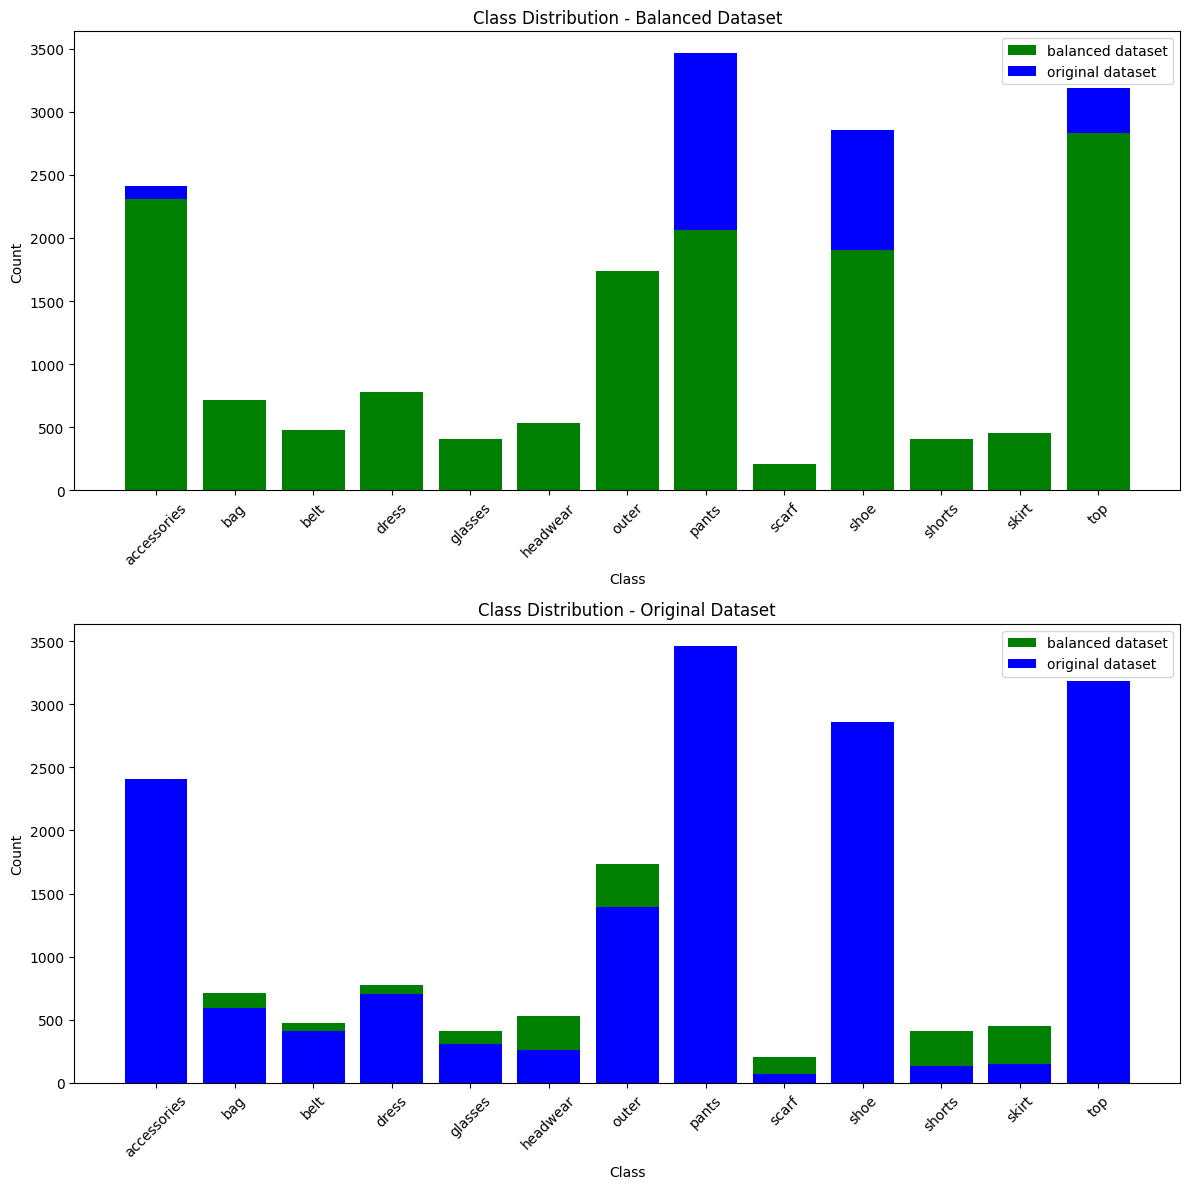


 Class distribution balanced dataset / original dataset:
headwear: 531 objects / 258 objects
outer: 1736 objects / 1392 objects
top: 2831 objects / 3187 objects
skirt: 453 objects / 151 objects
shoe: 1903 objects / 2855 objects
pants: 2060 objects / 3463 objects
bag: 715 objects / 590 objects
accessories: 2310 objects / 2411 objects
shorts: 411 objects / 137 objects
belt: 478 objects / 409 objects
dress: 776 objects / 703 objects
scarf: 207 objects / 69 objects
glasses: 409 objects / 308 objects


In [ ]:
# @title характеристики данных

## Анализ датасета изображений в формате YOLO

### Загрузка данных

images_dir_1 = '/content/Tdataset/images'
labels_dir_1 = '/content/Tdataset/labels'
images_dir_2 = '/content/images'
labels_dir_2 = '/content/labels'

image_files_1 = os.listdir(images_dir_1)
label_files_1 = os.listdir(labels_dir_1)
image_files_2 = os.listdir(images_dir_2)
label_files_2 = os.listdir(labels_dir_2)

print("total files in the balanced dataset: ", len(image_files_1))
print("total files in the original dataset: ", len(image_files_2))

### Анализ аннотаций

def read_yolo_annotations(label_file):
    annotations = []
    with open(label_file, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 5:
                class_id, x, y, width, height = map(float, values)
                annotations.append((int(class_id), x, y, width, height))
    return annotations

class_counts_1 = Counter()
for label_file in label_files_1:
    annotations = read_yolo_annotations(os.path.join(labels_dir_1, label_file))
    for class_id, _, _, _, _ in annotations:
        class_counts_1[class_id] += 1

class_counts_2 = Counter()
for label_file in label_files_2:
    annotations = read_yolo_annotations(os.path.join(labels_dir_2, label_file))
    for class_id, _, _, _, _ in annotations:
        class_counts_2[class_id] += 1


### Визуализация статистики по классам

class_ids_1 = list(class_counts_1.keys())
class_counts_list_1 = list(class_counts_1.values())
class_ids_2 = list(class_counts_2.keys())
class_counts_list_2 = list(class_counts_2.values())

pairs_1 = list(zip(class_ids_1, class_counts_list_1))
sorted_pairs_1 = sorted(pairs_1)
sorted_indices_1, sorted_values_1 = zip(*sorted_pairs_1)

pairs_2 = list(zip(class_ids_2, class_counts_list_2))
sorted_pairs_2 = sorted(pairs_2)
sorted_indices_2, sorted_values_2 = zip(*sorted_pairs_2)

class_labels_1 = [labels[class_id] for class_id in sorted_indices_1]
class_labels_2 = [labels[class_id] for class_id in sorted_indices_2]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.bar(class_labels_1, sorted_values_1, color='green', label='balanced dataset', zorder=2)
ax1.bar(class_labels_2, sorted_values_2, color='blue', label='original dataset', zorder=1)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution - Balanced Dataset')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

ax2.bar(class_labels_1, sorted_values_1, color='green', label='balanced dataset', zorder=1)
ax2.bar(class_labels_2, sorted_values_2, color='blue', label='original dataset', zorder=2)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution - Original Dataset')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()


print("\n Class distribution balanced dataset / original dataset:")
for class_id, count in class_counts_1.items():
    print(f"{labels[class_id]}: {count} objects", end=" / ")
    print(f"{class_counts_2[class_id]} objects")

### Выводы
Добиться более сбалансированого датасета не получится без генерации дополнительных изображений тк изображения содержащие редкие классы так же содержат в себе большие классы (этим и обусловлен такой дизбаланс) решить проблему можно было бы синтетическими данными на которых были бы только представители редких классов, такие "чистые" представители классов позволили бы сбалансировать датасет, однако тк задача решается на исходных данных ограничемся использованием undersampling частых и oversampling редких классов


## Baseline

###Загрузка требуемых пакетов

In [ ]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 29720, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 29720 (delta 163), reused 210 (delta 89), pack-reused 29380
Receiving objects: 100% (29720/29720), 15.42 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (21330/21330), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/78.2 GB disk)


### Выбор оптимальной модели

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov8n.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo8n

Ultralytics YOLOv8.2.54 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov8s.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo8s

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo8s2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov8m.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo8m

100% 49.7M/49.7M [00:00<00:00, 357MB/s]
Ultralytics YOLOv8.2.54 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo8m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov9t.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo9t

100% 4.74M/4.74M [00:00<00:00, 77.8MB/s]
New https://pypi.org/project/ultralytics/8.2.54 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.53 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9t.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo9n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mas

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov9s.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo9s

100% 14.7M/14.7M [00:00<00:00, 200MB/s]
Ultralytics YOLOv8.2.53 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo9s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

In [ ]:
!yolo task=detect mode=train data=dataset.yaml model=yolov10s.pt epochs=15 batch=8 imgsz=640 project=training_results name=T_yolo10s

100% 15.9M/15.9M [00:00<00:00, 126MB/s]
Ultralytics YOLOv8.2.54 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=training_results, name=T_yolo10s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

In [ ]:
# @title уведомление об окончании тренировки
from IPython.display import Audio
!wget --content-disposition 'https://www.dropbox.com/scl/fi/voszmke0f9vb522ogzgyv/positive_beeps.mp3?rlkey=wtgc33dd4hj4uxv7fvaknwk09&st=j5fxplqt&dl=0' -O sound.mp3
wn = Audio('/content/sound.mp3', autoplay=True)
display(wn)

wget: unrecognized option '--quite'
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


###выводы по экспериментам:

YOLOv8 вышла в 2023 и на данный момент является передовой моделью компании Ultralytics. Несмотря на то что модель старше YOLOv9 и YOLOv10 (разработанной специально для детекции), YOLOv8 показывает лучшие результаты на нашем датасете в связи с его небольшим размером. Несмотря на то что YOLOv9s имеет лучшие показатели на тетстах, она тяжелее, при этом её показатели незначительно выше. Поэтому в дальнейшем будем использовать именно YOLOv8s и на финальных тестах обучим YOLOv8m.

// преймущество выбора  YOLOv8s на данном этапе так же заключается в скорости обучения по сравнению с большей моделью что позволит быстрее получать результаты экспериментов

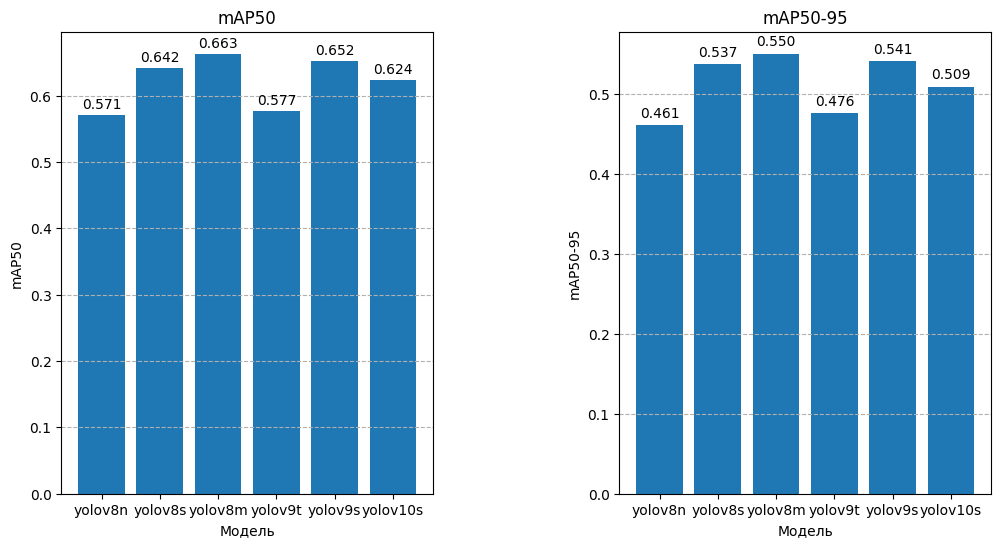

In [ ]:
# @title mAP visualisation (15 epoch)
import matplotlib.pyplot as plt
# Данные для диаграммы
metrics = ['yolov8n', 'yolov8s', 'yolov8m','yolov9t','yolov9s', 'yolov10s']
map50 = [0.571, 0.642,  0.663,0.577,0.652,0.624]
mAP50_95 = [ 0.461, 0.537,0.55,0.476,0.541,0.509]
# Создание фигуры и осей
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Построение первой диаграммы для mAP50
ax1.bar(metrics, map50)
ax1.set_xlabel('Модель')
ax1.set_ylabel('mAP50')
ax1.set_title('mAP50')
ax1.grid(axis='y', linestyle='--')

# Построение второй диаграммы для mAP50-95
ax2.bar(metrics, mAP50_95)
ax2.set_xlabel('Модель')
ax2.set_ylabel('mAP50-95')
ax2.set_title('mAP50-95')
ax2.grid(axis='y', linestyle='--')

# Отображение значений над столбцами
for ax, values in zip([ax1, ax2], [map50, mAP50_95]):
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

# Регулировка расстояния между диаграммами
plt.subplots_adjust(wspace=0.5)

# Отображение диаграмм
plt.show()

## Метрики

### Метрики выбранной baseline модели на 15 эпохах

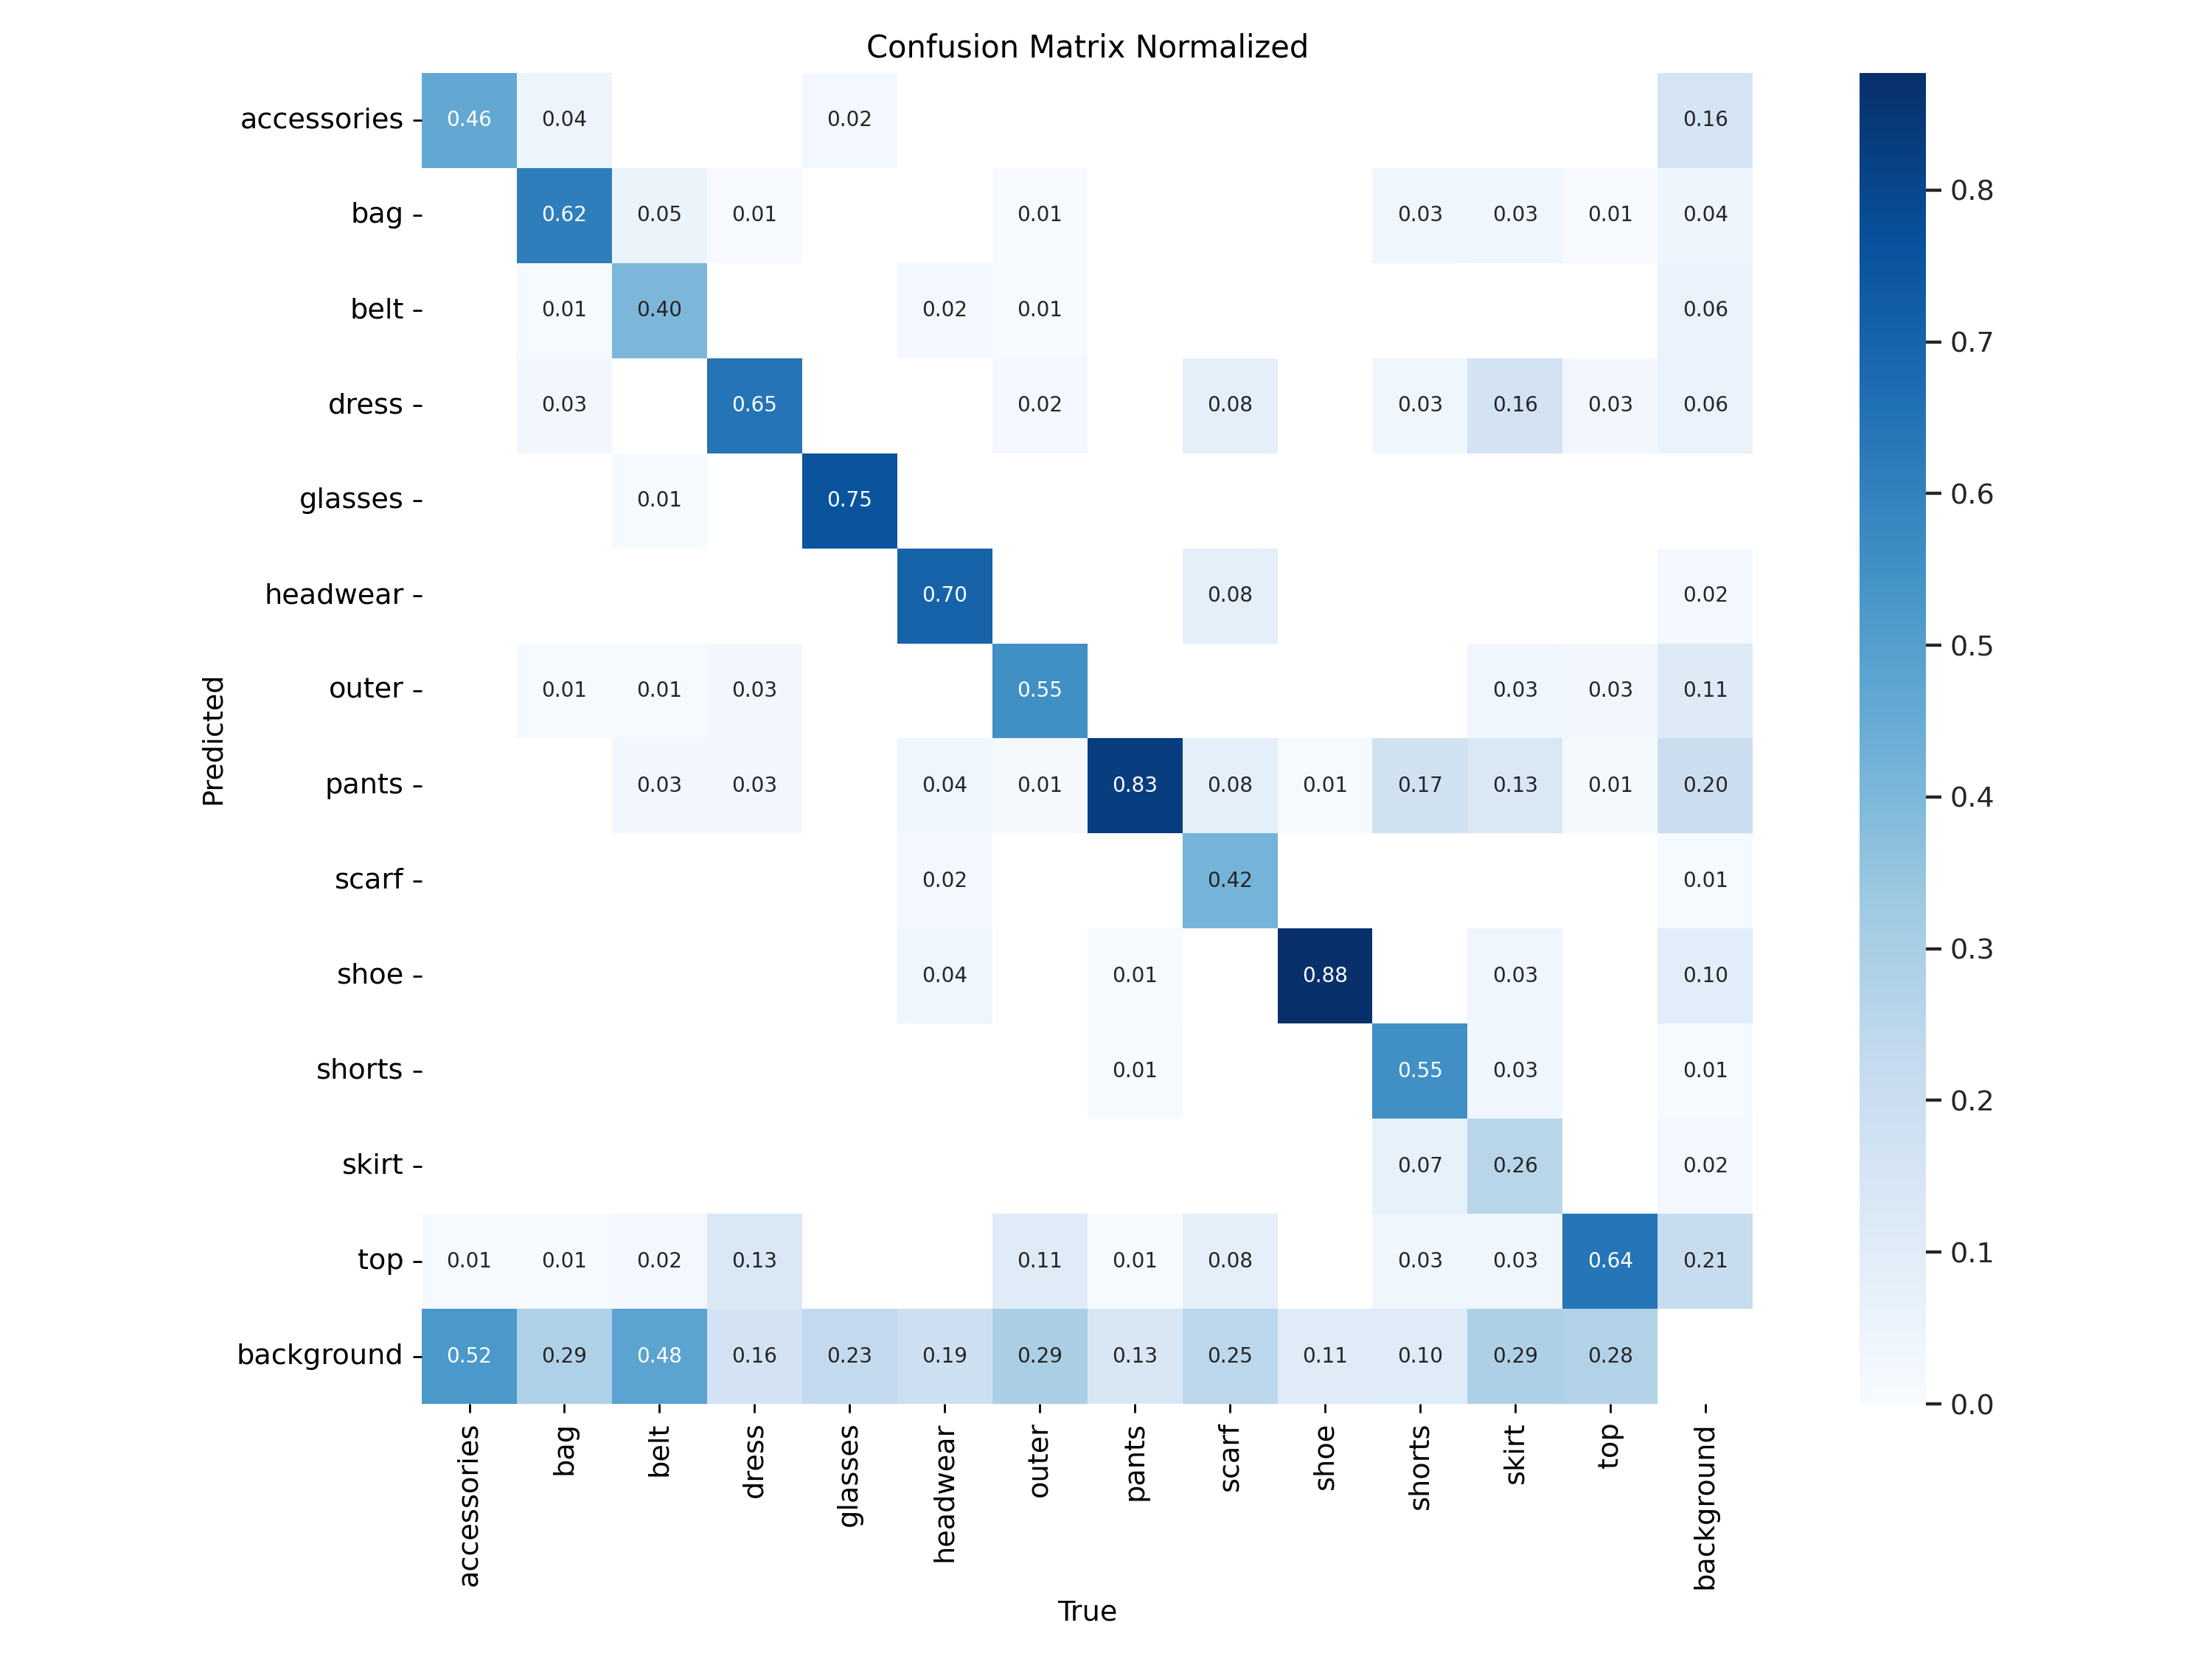

In [ ]:
from IPython.display import Image, display
Image(filename=f'/content/training_results/T_yolo8s2/confusion_matrix_normalized.png',width = 1200)

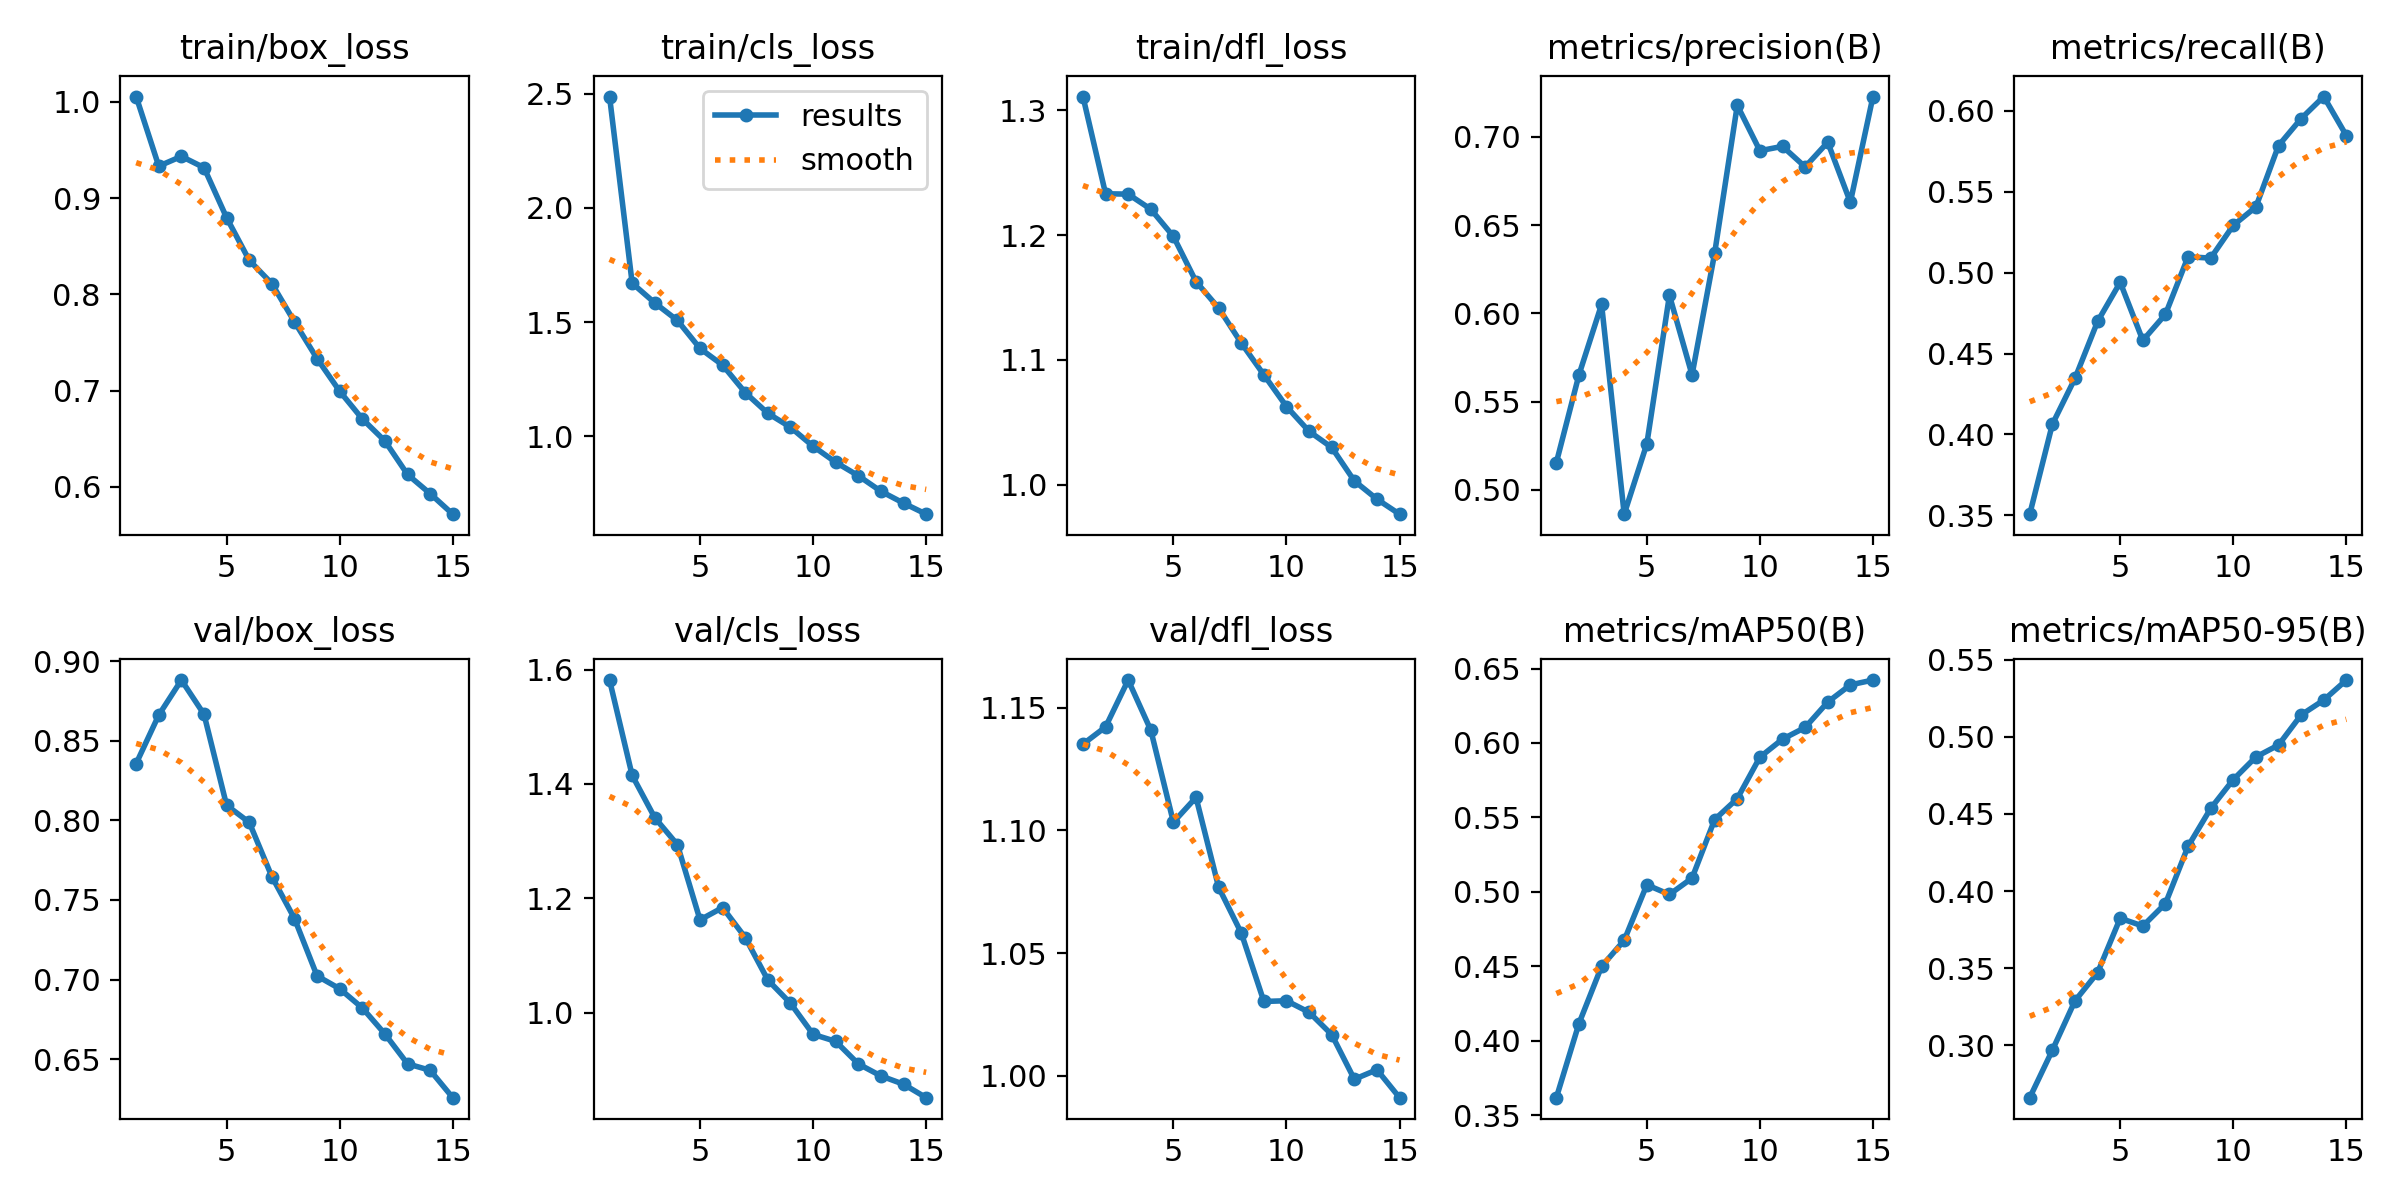

In [ ]:
Image(filename=f'/content/training_results/T_yolo8s2/results.png',width = 1200)

## Решение

###тренировка модели

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# загрузка официальных YOLOv8 весов
!wget --quiet https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8s.pt -O yolov8sW.pt
!wget --quiet https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8m.pt -O yolov8mW.pt

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/yolov8sW.pt', task='detect')  # load a pretrained YOLOv8n detection model
result = model.train( # train the model
    data='dataset.yaml',
    epochs=15,
    batch=-1,
    project='training_results',
    name='yolo8sT1',
    device='cuda',
    seed=777
    )

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8sW.pt, data=dataset.yaml, epochs=15, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=training_results, name=yolo8sT14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=777, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /content/datasets/labels/train... 2657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2657/2657 [00:01<00:00, 1636.22it/s]


train: New cache created: /content/datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/labels/val... 664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 664/664 [00:00<00:00, 814.64it/s]

val: New cache created: /content/datasets/labels/val.cache


Plotting labels to training_results/yolo8sT14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000609375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to training_results/yolo8sT14
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      9.37G      1.101      3.083      1.418         45        640: 100%|██████████| 69/69 [01:55<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.14s/it]

                   all        664       2929      0.479        0.4      0.383       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15       9.6G     0.9158      1.755       1.21         56        640: 100%|██████████| 69/69 [01:52<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]

                   all        664       2929       0.38      0.416      0.358      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      9.52G     0.9332      1.574      1.217         32        640: 100%|██████████| 69/69 [01:42<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


                   all        664       2929      0.557      0.486      0.489      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      9.37G     0.8913      1.402      1.181         46        640: 100%|██████████| 69/69 [01:58<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.15s/it]


                   all        664       2929      0.593      0.504      0.527      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      9.61G     0.8442      1.279      1.159         51        640: 100%|██████████| 69/69 [01:57<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.49s/it]


                   all        664       2929      0.676      0.518       0.58      0.448
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      9.68G      0.811      1.252      1.134         15        640: 100%|██████████| 69/69 [01:44<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


                   all        664       2929      0.707      0.578      0.636      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      9.54G     0.7743       1.09      1.101         20        640: 100%|██████████| 69/69 [01:52<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.09s/it]


                   all        664       2929      0.715      0.609      0.662      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      9.41G     0.7314     0.9816      1.068         30        640: 100%|██████████| 69/69 [01:42<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:15<00:00,  1.77s/it]

                   all        664       2929      0.767      0.607      0.678      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      9.61G     0.7045     0.9118      1.048         14        640: 100%|██████████| 69/69 [01:37<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


                   all        664       2929      0.745      0.659       0.71      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15       9.6G     0.6859       0.84      1.036         33        640: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.58s/it]

                   all        664       2929      0.782      0.658      0.732      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      9.54G     0.6502     0.7623      1.011         26        640: 100%|██████████| 69/69 [01:35<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


                   all        664       2929      0.796      0.681      0.755      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      9.39G      0.612     0.6869     0.9878         18        640: 100%|██████████| 69/69 [01:30<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]

                   all        664       2929      0.842      0.686      0.763      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      9.54G     0.5887     0.6344     0.9682         29        640: 100%|██████████| 69/69 [01:28<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:16<00:00,  1.83s/it]

                   all        664       2929      0.855       0.69      0.776      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      9.61G     0.5591     0.5778     0.9577         12        640: 100%|██████████| 69/69 [01:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.46s/it]

                   all        664       2929      0.871      0.708      0.792      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      9.54G     0.5388     0.5319     0.9421         26        640: 100%|██████████| 69/69 [01:27<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        664       2929       0.85       0.73        0.8       0.69



15 epochs completed in 0.509 hours.
Optimizer stripped from training_results/yolo8sT14/weights/last.pt, 22.5MB
Optimizer stripped from training_results/yolo8sT14/weights/best.pt, 22.5MB

Validating training_results/yolo8sT14/weights/best.pt...
Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,130,615 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


                   all        664       2929      0.849      0.731        0.8       0.69
           accessories        223        435      0.812      0.406      0.507      0.294
                   bag        114        153      0.832      0.712       0.79      0.692
                  belt         62        113      0.766      0.348      0.538       0.37
                 dress        118        175      0.776      0.617      0.696      0.612
               glasses         69         75      0.921       0.78      0.821      0.687
              headwear         83         92      0.856      0.906      0.949      0.876
                 outer        182        341      0.799      0.727      0.782      0.662
                 pants        245        412      0.837      0.726      0.819      0.725
                 scarf         36         46      0.997      0.891      0.905      0.765
                  shoe        182        375       0.88      0.844      0.912      0.807
                short

Модель YOLOv8s показывает хорошие результаты, запустим итоговое обучение на данных параметрах и датасете модели YOLOv8m (60 эпох)

In [ ]:
# Load YOLOv8n, train it on COCO128 for 3 epochs and predict an image with it
from ultralytics import YOLO

model = YOLO('/content/yolov8mW.pt', task='detect')  # load a pretrained YOLOv8n detection model
result = model.train( # train the model
    data='dataset.yaml',
    epochs=60,
    patience = 10,
    batch=-1,
    project='training_results',
    name='yolo8mT1',
    device='cuda',
    seed=777
    )

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov8mW.pt, data=dataset.yaml, epochs=60, time=None, patience=10, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=training_results, name=yolo8mT1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=777, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.30G reserved, 0.24G allocated, 14.20G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25863847        79.1         0.665         29.39         125.1        (1, 3, 640, 640)                    list
    25863847       158.2         1.007         31.67         62.63        (2, 3, 640, 640)                    list
    25863847       316.4         1.808         42.84         66.77        (4, 3, 640, 640)                    list
    25863847       632.8         3.274         73.24         97.31        (8, 3, 640, 640)                    list
    25863847        1266         6.315         146.4         169.9       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 21 for CUDA:0 8.74G/14.75G (59%) ✅


train: Scanning /content/datasets/labels/train... 2657 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2657/2657 [00:06<00:00, 382.24it/s]

train: New cache created: /content/datasets/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/labels/val... 664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 664/664 [00:01<00:00, 351.83it/s]

val: New cache created: /content/datasets/labels/val.cache


Plotting labels to training_results/yolo8mT1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0004921875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to training_results/yolo8mT1
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      9.58G     0.9288      2.287      1.289         86        640: 100%|██████████| 127/127 [01:52<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


                   all        664       2977      0.564      0.412      0.455      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      9.71G     0.9058       1.65      1.233         70        640: 100%|██████████| 127/127 [01:46<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


                   all        664       2977      0.587      0.362      0.396      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60       9.6G     0.9722      1.671      1.278         75        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


                   all        664       2977      0.559       0.46      0.472      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      9.71G     0.9793      1.621       1.28         90        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


                   all        664       2977      0.535      0.453      0.468      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      9.68G     0.9336      1.497      1.252         80        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]


                   all        664       2977      0.618      0.493      0.526      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      9.75G     0.9057      1.417       1.24         57        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


                   all        664       2977      0.636      0.481      0.542      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      9.47G     0.8591      1.321      1.201         96        640: 100%|██████████| 127/127 [01:45<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


                   all        664       2977      0.624      0.581      0.604       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      9.48G     0.8361      1.256       1.19         96        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


                   all        664       2977      0.663      0.594      0.639      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      9.58G     0.8219      1.208      1.179         96        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]


                   all        664       2977      0.698      0.584      0.645      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      9.73G     0.7938      1.138      1.159         90        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


                   all        664       2977      0.721      0.586      0.664      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      9.69G     0.7665      1.075      1.138         71        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

                   all        664       2977      0.738      0.634      0.694      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      9.56G     0.7629      1.053      1.132         93        640: 100%|██████████| 127/127 [01:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


                   all        664       2977      0.697      0.661      0.701      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      9.45G     0.7431      1.014      1.123         57        640: 100%|██████████| 127/127 [01:45<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        664       2977      0.768      0.646      0.721      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      9.62G     0.7207     0.9557      1.108         93        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

                   all        664       2977      0.759      0.629      0.705      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      9.58G     0.7162     0.9352      1.101        110        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

                   all        664       2977      0.757      0.657      0.724      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      9.45G     0.7156     0.9341       1.11         55        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

                   all        664       2977      0.747       0.67      0.734      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      9.65G     0.6943      0.891      1.084        110        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

                   all        664       2977      0.765      0.676      0.755      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      9.58G     0.6748     0.8435      1.079        105        640: 100%|██████████| 127/127 [01:45<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

                   all        664       2977      0.777      0.696      0.753      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      9.52G     0.6763     0.8339      1.079         87        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all        664       2977      0.793      0.699      0.766      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       9.6G     0.6589     0.7944       1.07         78        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.03s/it]

                   all        664       2977      0.838      0.688       0.77       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      9.57G     0.6593     0.7773       1.07         72        640: 100%|██████████| 127/127 [01:44<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        664       2977      0.755      0.743      0.772      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      9.74G     0.6426     0.7465      1.058        102        640: 100%|██████████| 127/127 [01:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]

                   all        664       2977      0.849      0.718      0.786      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      9.64G     0.6423     0.7422      1.056         89        640: 100%|██████████| 127/127 [01:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

                   all        664       2977      0.828      0.695      0.767      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      9.48G     0.6369     0.7201      1.049        110        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]

                   all        664       2977      0.806      0.736      0.791      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      9.49G     0.6185     0.6931      1.039        116        640: 100%|██████████| 127/127 [01:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

                   all        664       2977      0.857      0.741      0.809      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      9.64G     0.6136     0.6836      1.038        108        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all        664       2977      0.882      0.743      0.814      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      9.48G     0.6081     0.6655       1.04         96        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

                   all        664       2977      0.852       0.75      0.818      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      9.49G     0.6043     0.6455      1.029         88        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

                   all        664       2977      0.854      0.741      0.809      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      9.59G     0.5966      0.645       1.03        106        640: 100%|██████████| 127/127 [01:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

                   all        664       2977      0.833      0.771      0.813      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      9.73G     0.5857     0.6267      1.024        115        640: 100%|██████████| 127/127 [01:45<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

                   all        664       2977      0.863      0.748      0.816      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      9.45G      0.577     0.6132       1.02        147        640: 100%|██████████| 127/127 [01:44<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

                   all        664       2977      0.828      0.766      0.805      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      9.66G       0.57     0.5868      1.009        126        640: 100%|██████████| 127/127 [01:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

                   all        664       2977      0.881      0.746      0.828      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      9.71G     0.5632     0.5726       1.01         92        640: 100%|██████████| 127/127 [01:44<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

                   all        664       2977      0.868      0.774      0.834      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      9.69G      0.558     0.5617      1.003         67        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

                   all        664       2977      0.865      0.786       0.84      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      9.59G     0.5481     0.5465     0.9967         68        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]

                   all        664       2977      0.888      0.768      0.836      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      9.74G     0.5539     0.5497      1.003        111        640: 100%|██████████| 127/127 [01:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all        664       2977      0.864      0.792      0.837      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      9.73G     0.5451     0.5357     0.9937         72        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

                   all        664       2977      0.874      0.778      0.837      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      9.66G      0.539     0.5298     0.9968         94        640: 100%|██████████| 127/127 [01:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        664       2977      0.891      0.772      0.842      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      9.74G     0.5294     0.5048     0.9835         91        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        664       2977      0.889      0.787      0.847      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      9.49G     0.5238     0.4955     0.9834         93        640: 100%|██████████| 127/127 [01:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.02it/s]

                   all        664       2977      0.901      0.795      0.853      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      9.63G     0.5229     0.4962     0.9826        110        640: 100%|██████████| 127/127 [01:43<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

                   all        664       2977      0.891       0.79       0.85      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      9.49G     0.5202     0.4863     0.9853         97        640: 100%|██████████| 127/127 [01:44<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

                   all        664       2977      0.893      0.785       0.85      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      9.47G     0.5095     0.4683     0.9761        138        640: 100%|██████████| 127/127 [01:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all        664       2977      0.894      0.796      0.848      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      9.63G     0.5013     0.4646     0.9728        107        640: 100%|██████████| 127/127 [01:45<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

                   all        664       2977      0.881      0.805      0.854      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      9.53G     0.4972     0.4545     0.9735         95        640: 100%|██████████| 127/127 [01:44<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

                   all        664       2977      0.908      0.786      0.851      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      9.48G     0.4925     0.4487     0.9706        101        640: 100%|██████████| 127/127 [01:44<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.27it/s]

                   all        664       2977      0.892        0.8      0.856      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      9.58G     0.4912     0.4367     0.9678         92        640: 100%|██████████| 127/127 [01:41<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

                   all        664       2977      0.897      0.799      0.856       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60       9.5G     0.4968      0.442     0.9706         61        640: 100%|██████████| 127/127 [01:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]

                   all        664       2977      0.891      0.802      0.859      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      9.48G     0.4817     0.4235     0.9615         85        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]

                   all        664       2977      0.907      0.793      0.861      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      9.64G      0.472     0.4207     0.9616         94        640: 100%|██████████| 127/127 [01:42<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

                   all        664       2977      0.894       0.81      0.862      0.768


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      9.49G     0.3967     0.3102     0.8761         45        640: 100%|██████████| 127/127 [01:46<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]

                   all        664       2977      0.875      0.814      0.856       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      9.46G     0.3865     0.2982     0.8727         54        640: 100%|██████████| 127/127 [01:40<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.03it/s]

                   all        664       2977      0.889      0.809      0.852      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      9.62G     0.3784     0.2876     0.8717         44        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

                   all        664       2977       0.91       0.81      0.858      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60       9.7G      0.378     0.2834     0.8704         91        640: 100%|██████████| 127/127 [01:40<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

                   all        664       2977      0.911      0.805       0.86      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      9.45G      0.374     0.2739     0.8652         47        640: 100%|██████████| 127/127 [01:41<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.00it/s]

                   all        664       2977      0.898      0.816      0.863      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      9.61G     0.3653     0.2681     0.8608         46        640: 100%|██████████| 127/127 [01:41<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

                   all        664       2977      0.908      0.811      0.862      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      9.71G     0.3605     0.2587     0.8578         37        640: 100%|██████████| 127/127 [01:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

                   all        664       2977      0.899      0.816      0.861      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      9.66G     0.3524      0.254     0.8577         57        640: 100%|██████████| 127/127 [01:39<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all        664       2977       0.91       0.81      0.863      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      9.63G      0.349     0.2525      0.853         48        640: 100%|██████████| 127/127 [01:39<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:15<00:00,  1.07it/s]

                   all        664       2977      0.917      0.809      0.865      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      9.52G     0.3487     0.2494     0.8539         33        640: 100%|██████████| 127/127 [01:48<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

                   all        664       2977      0.907      0.818      0.865      0.778



60 epochs completed in 2.064 hours.
Optimizer stripped from training_results/yolo8mT1/weights/last.pt, 52.0MB
Optimizer stripped from training_results/yolo8mT1/weights/best.pt, 52.0MB

Validating training_results/yolo8mT1/weights/best.pt...
Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


                   all        664       2977      0.907      0.818      0.865      0.778
           accessories        233        507      0.892      0.531      0.659      0.415
                   bag        114        157      0.782      0.732       0.79      0.671
                  belt         55         79      0.836      0.608      0.646      0.506
                 dress         92        152      0.828      0.789      0.842      0.783
               glasses         76         85      0.962      0.835      0.903      0.773
              headwear         91        104      0.971      0.978      0.994       0.96
                 outer        195        361      0.892      0.729      0.814      0.712
                 pants        241        394      0.912      0.789      0.875      0.791
                 scarf         35         41      0.984          1      0.995      0.974
                  shoe        184        393      0.907      0.835       0.89      0.804
                short

#### Метрики

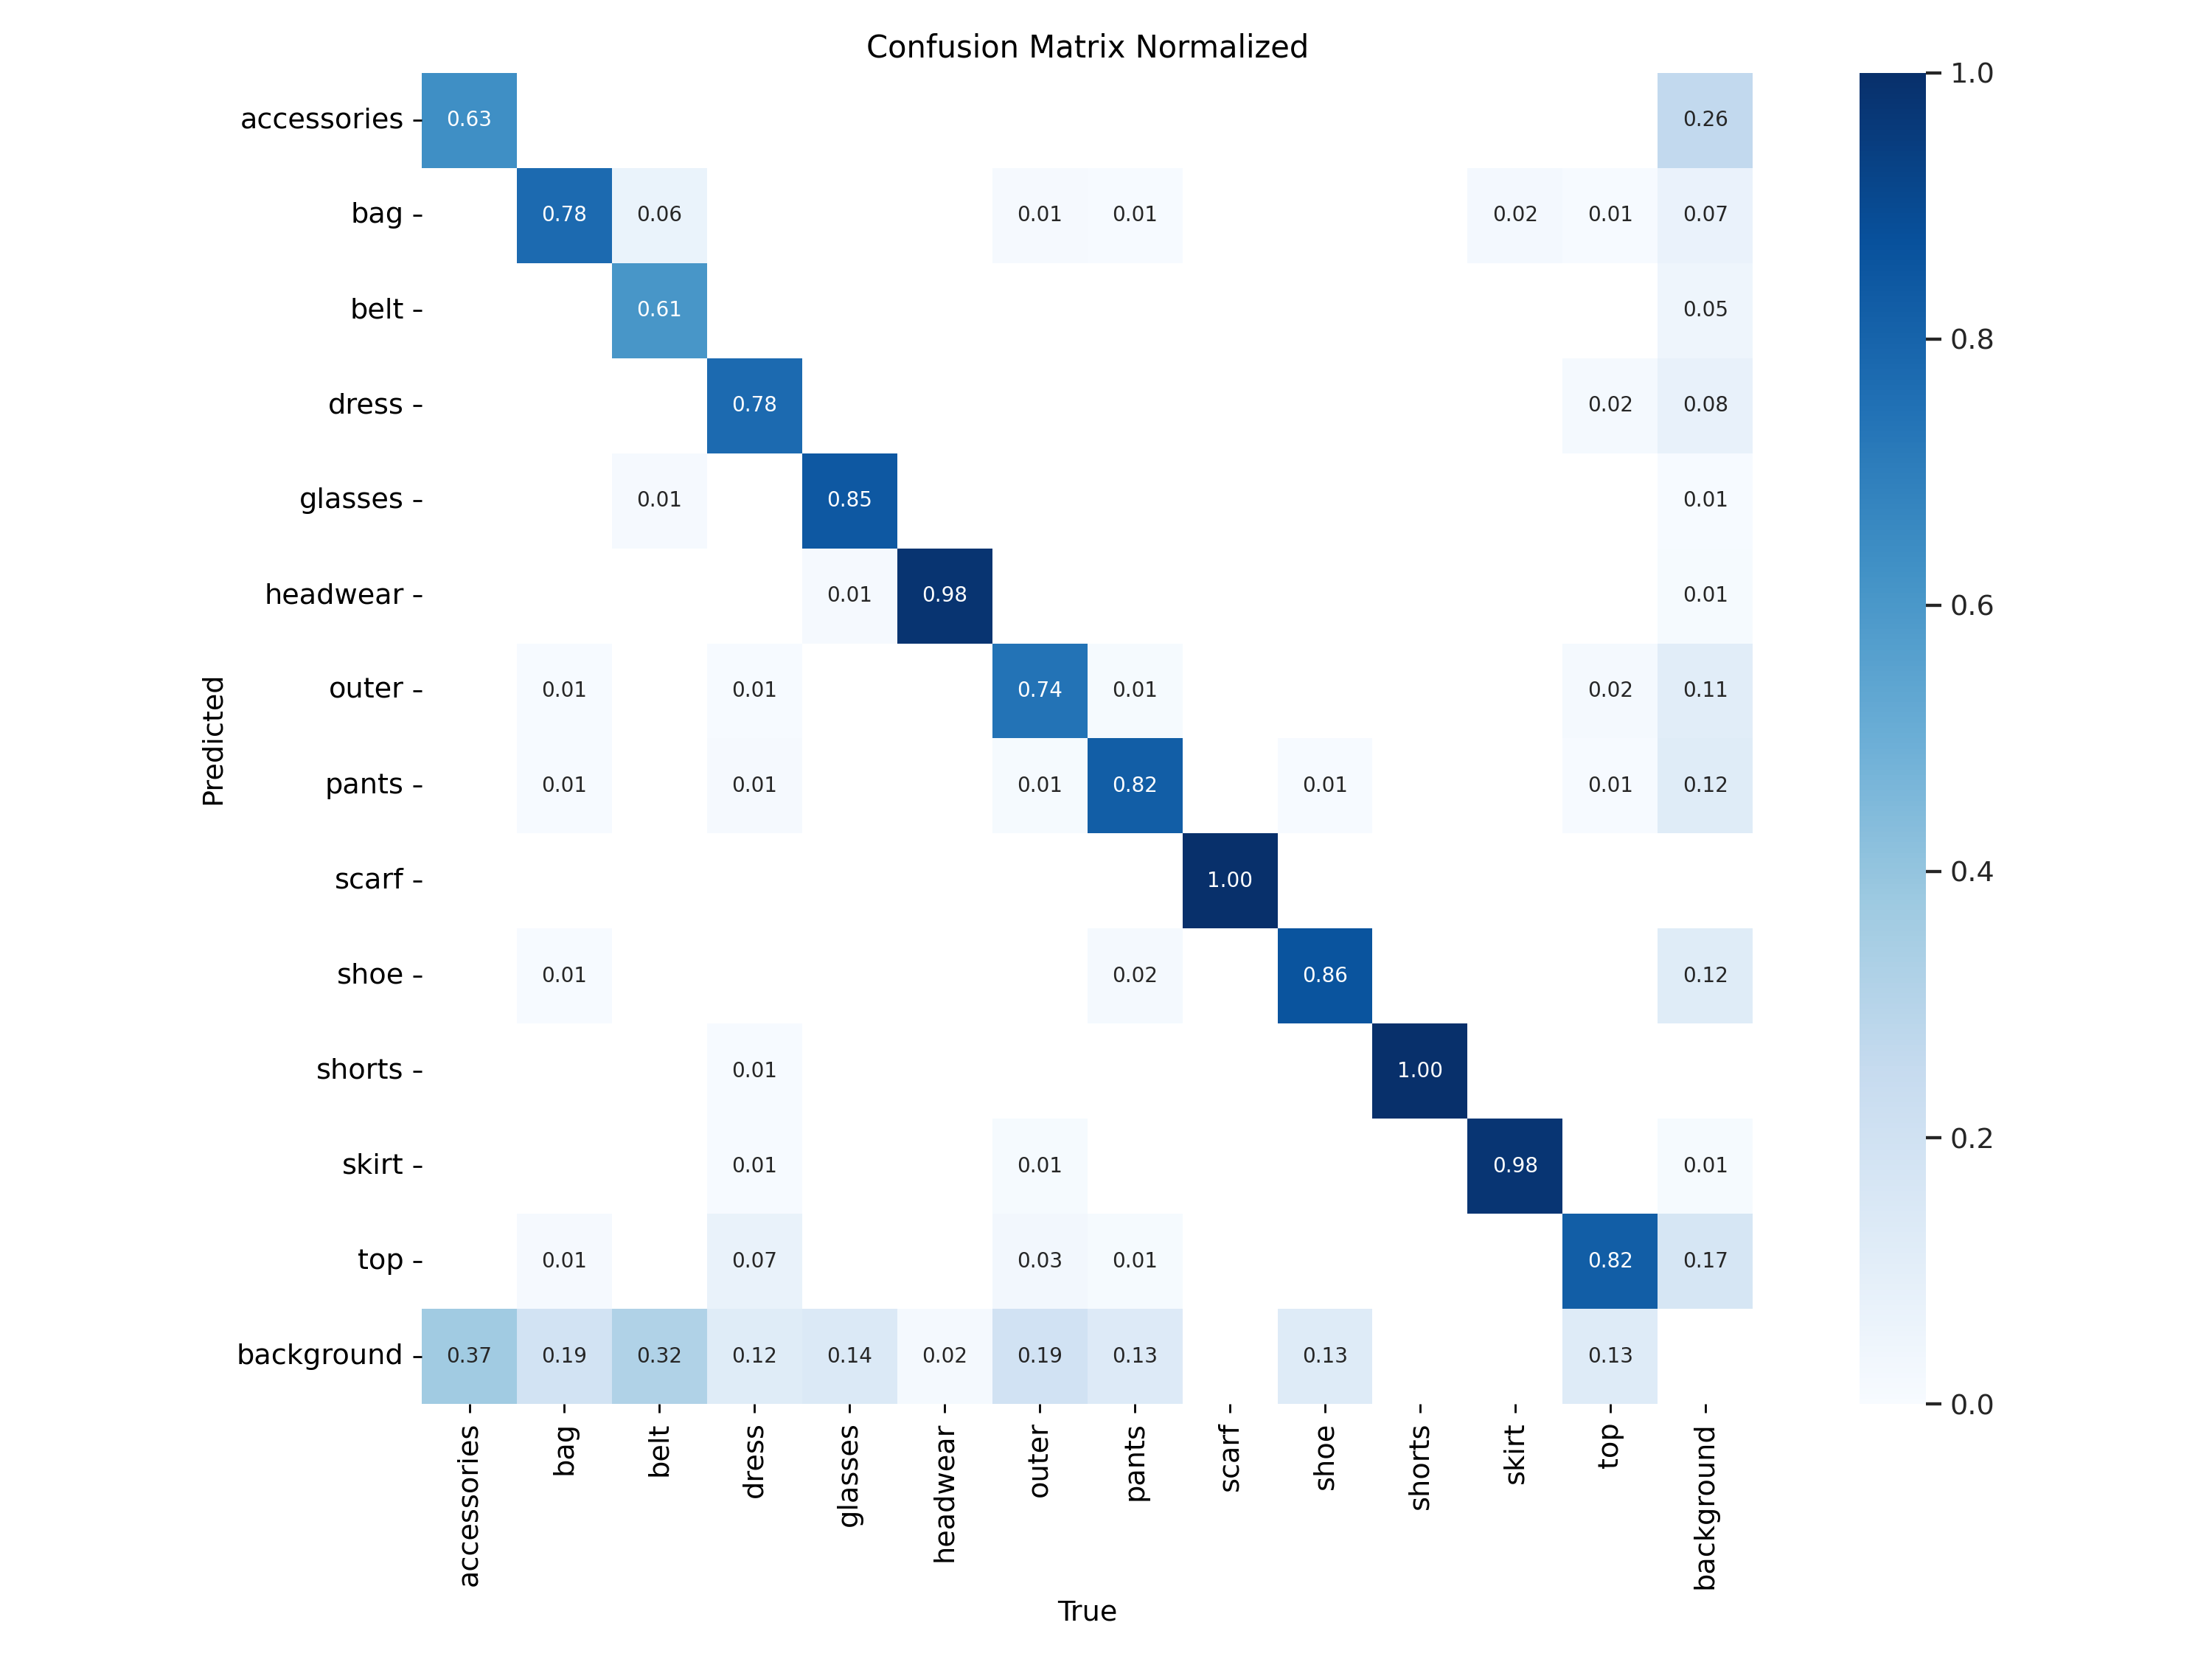

In [ ]:
from IPython.display import Image, display
Image(filename=f'/content/training_results/yolo8mT1/confusion_matrix_normalized.png',width = 1200)

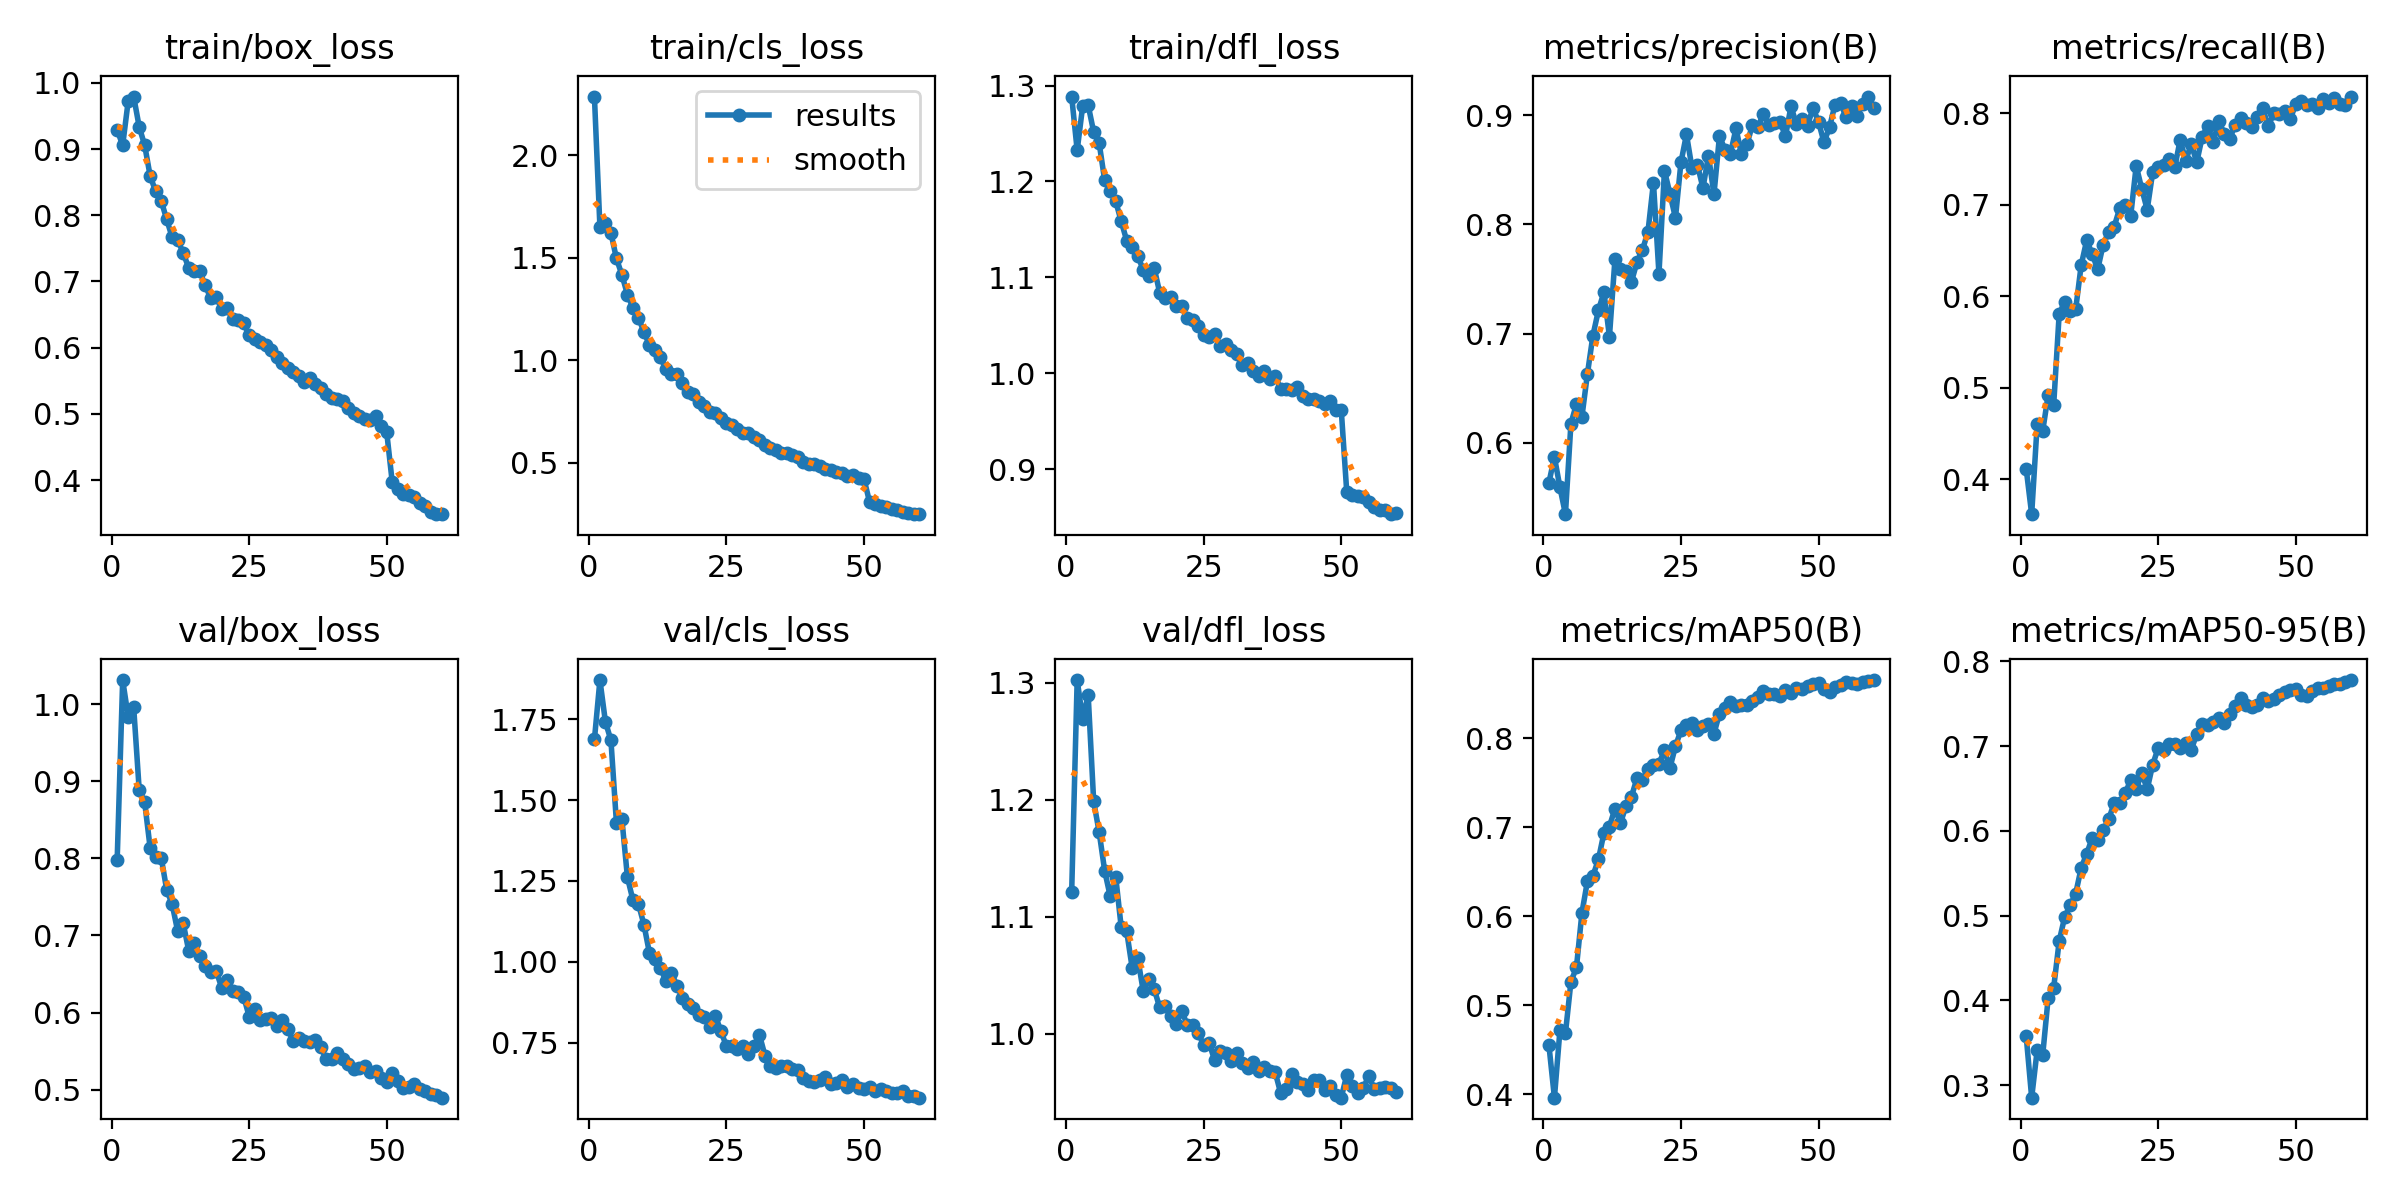

In [ ]:
Image(filename=f'/content/training_results/yolo8mT1/results.png',width = 1200)

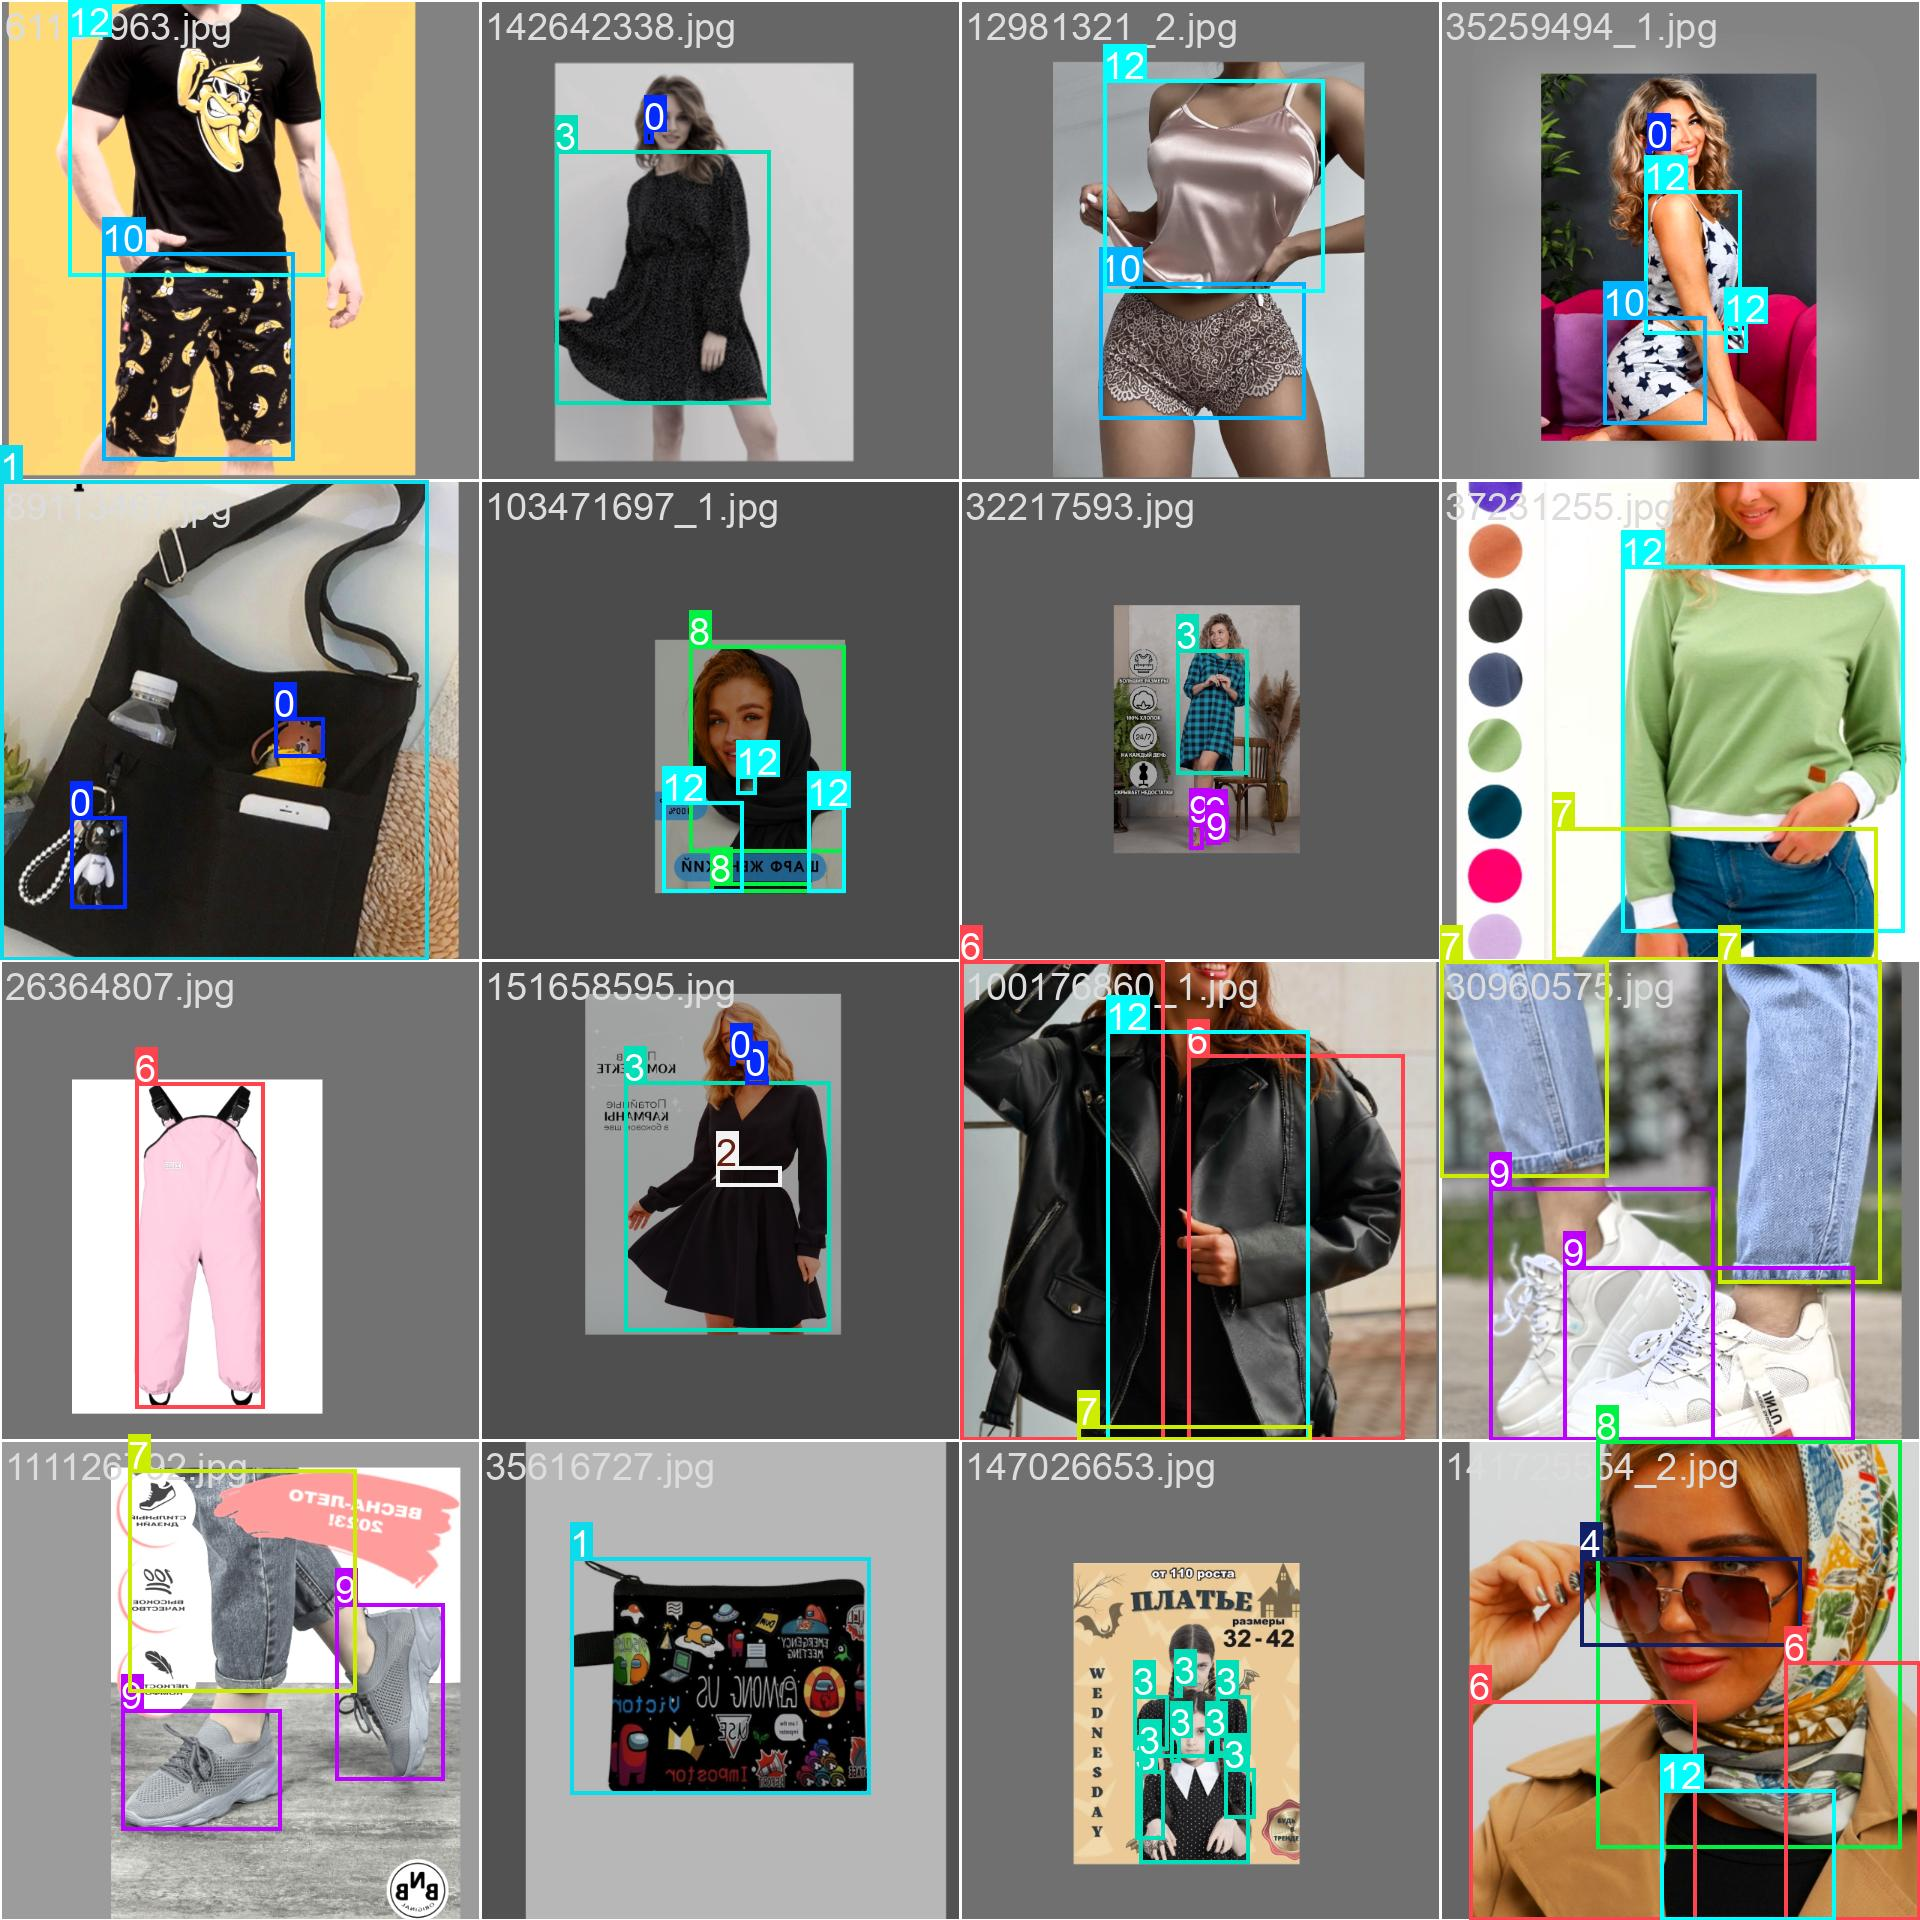

In [ ]:
# @title примет батчей для обучения
Image(filename=f'/content/training_results/yolo8mT1/train_batch6352.jpg',width = 1200)

###зададим вспомогательные функции

In [ ]:
import os
import cv2
import numpy as np
from IPython.display import Image, display

In [ ]:
# @title вывод цветов в которые красим классы (тк цифры в качестве аргументов colors не информативны)
def show_color_palette(colors):

    # Размер квадратика для каждого цвета
    square_size = 50
    # Создание изображения для палитры цветов
    palette_width = len(colors) * square_size
    palette_height = square_size
    palette_image = np.zeros((palette_height, palette_width, 3), dtype=np.uint8)

    # Заполнение изображения квадратиками цветов
    for i, color in enumerate(colors):
        x1 = i * square_size
        x2 = x1 + square_size
        y1 = 0
        y2 = y1 + square_size
        palette_image[y1:y2, x1:x2] = color

    # Создание папки "./colors" если она не существует
    colors_dir = "./colors"
    os.makedirs(colors_dir, exist_ok=True)

    # Сохранение палитры цветов в файл "colorPalet.jpg"
    palette_image_path = os.path.join(colors_dir, "colorPalet.jpg")
    cv2.imwrite(palette_image_path, palette_image)
    display(Image(palette_image_path))

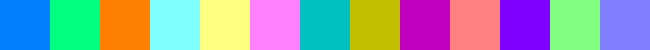

In [ ]:
colors = [
        (255, 128, 0), (128, 255, 0), (0, 128, 255), (255, 255, 128), (128, 255, 255),
        (255, 128, 255), (192, 192, 0), (0, 192, 192), (192, 0, 192), (128, 128, 255),
        (255, 0, 128), (128, 255, 128), (255, 128, 128)
    ]
show_color_palette(colors) # реальные цвета разметки

In [ ]:
# @title функция для рисования boundary_boxes
def draw_boundary_boxes(image_path, labels_path, class_labels):
    # Загрузка изображения
    image = cv2.imread(image_path)

    # Чтение координат boundary boxes из файла разметки
    with open(labels_path, 'r') as f:
        lines = f.readlines()

    # Рисование boundary boxes на изображении
    for line in lines:
        class_id, x, y, width, height = map(float, line.strip().split())
        class_id = int(class_id)
        x1 = int((x - width / 2) * image.shape[1])
        y1 = int((y - height / 2) * image.shape[0])
        x2 = int((x + width / 2) * image.shape[1])
        y2 = int((y + height / 2) * image.shape[0])
        color = colors[int(class_id) % len(colors)] # логика выбора цвета класса
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        class_name = class_labels[class_id]
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2) #настройка шрифта

    # Создание папки "./pred" если она не существует
    pred_dir = "./pred"
    os.makedirs(pred_dir, exist_ok=True)

    # Сохранение изображения с boundary boxes
    pred_image_path = os.path.join(pred_dir, "predImg.jpg")
    base_name, ext = os.path.splitext(pred_image_path)

    # Проверка существования файла "predImg.jpg"
    i = 1
    while os.path.exists(pred_image_path):
        pred_image_path = f"{base_name}({i}){ext}"
        i += 1

    cv2.imwrite(pred_image_path, image)

    print(f"Saved image with boundary boxes to {pred_image_path}")
    display(Image(pred_image_path))

Saved image with boundary boxes to ./pred/predImg.jpg


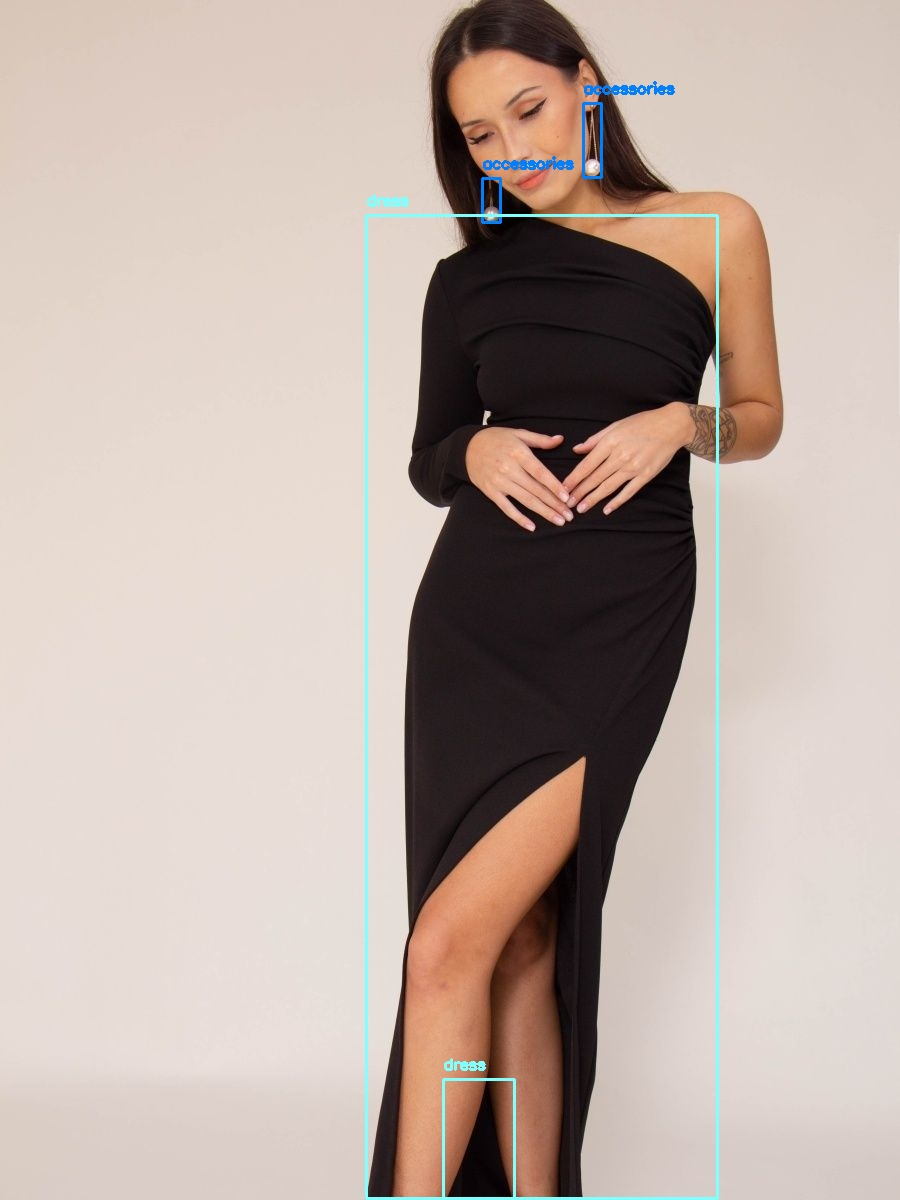

In [ ]:
draw_boundary_boxes("./images/100021350.jpg", "./labels/100021350.txt",labels) # тестовое изображение




###зададим функции для предсказания и обработки результатов


In [ ]:
# @title Функция для обработки изображения
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)

    results = model(image)[0]

    # Получение оригинального изображения и результатов
    image = results.orig_img
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xywhn.cpu().numpy()
    boxes_xyxy = results.boxes.xyxy.cpu().numpy().astype(np.int32)


    # Подготовка словаря для группировки результатов по классам
    grouped_objects = {}

    # Рисование рамок и группировка результатов
    for class_id, box, box_xy in zip(classes, boxes, boxes_xyxy):
        class_name = classes_names[int(class_id)]
        color = colors[int(class_id) % len(colors)]  # Выбор цвета для класса

        if class_name not in grouped_objects:
            grouped_objects[class_name] = []
        grouped_objects[class_name].append(box)

        # Рисование рамок на изображении
        x1, y1, x2, y2 = box_xy
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Сохранение измененного изображения
    image_name = os.path.basename(image_path)[:-4]

    new_image_path = os.path.join(predImgPath, image_name+'_yolo.jpg')
    cv2.imwrite(new_image_path, image)
    # Сохранение данных в текстовый файл
    text_file_path = os.path.join(predLabelPath, image_name+ '_data.txt')

    with open(text_file_path, 'w') as f:
        for class_name, details in grouped_objects.items():
            for detail in details:
                f.write(f"{labels.index(class_name)} {detail[0]} {detail[1]} {detail[2]} {detail[3]}\n")

    print(f"Processed {image_path}:")
    print(f"Saved bounding-box image to {new_image_path}")
    print(f"Saved data to {text_file_path}")

### Протестируем работоспособность модели и написанных функций

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # установка кодировки UTF-8 во избежеание ошибок при загрузке файлов

#Скачивание предобученной нами модели
!wget --content-disposition 'https://www.dropbox.com/scl/fi/rchv6ph16yiwhlst853g2/yolov8m-0.865-0.778.pt?rlkey=ncgs124oe4nujn8hnkxiaakby&st=qhc3lii2&dl=0' -O yolov8Pretrained.pt
yoloPretrained = '/content/yolov8Pretrained.pt'

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os

# зададим параметры модели
predImgPath = "./pred/img"
predLabelPath = "./pred/labels"
os.makedirs(predImgPath, exist_ok = True)
os.makedirs(predLabelPath, exist_ok = True)

modelPath = yoloPretrained
#modelPath = "/content/training_results/yolo8sT12/weights/best.pt"

model = YOLO(modelPath, task='detect')

# Список цветов для различных классов
colors = [
        (255, 128, 0), (128, 255, 0), (0, 128, 255), (255, 255, 128), (128, 255, 255),
        (255, 128, 255), (192, 192, 0), (0, 192, 192), (192, 0, 192), (128, 128, 255),
        (255, 0, 128), (128, 255, 128), (255, 128, 128)
    ]


In [ ]:
processedImage = '100115571.jpg' #задаём изображение

In [ ]:
process_image('/content/images/'+processedImage) #Предсказание модели


0: 640x480 1 accessories, 2 belts, 2 pantss, 1 top, 12.4ms
Speed: 3.6ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)
Processed /content/images/100115571.jpg:
Saved bounding-box image to ./pred/img/100115571_yolo.jpg
Saved data to ./pred/labels/100115571_data.txt


PREDICTET IMG
Saved image with boundary boxes to ./pred/predImg(3).jpg


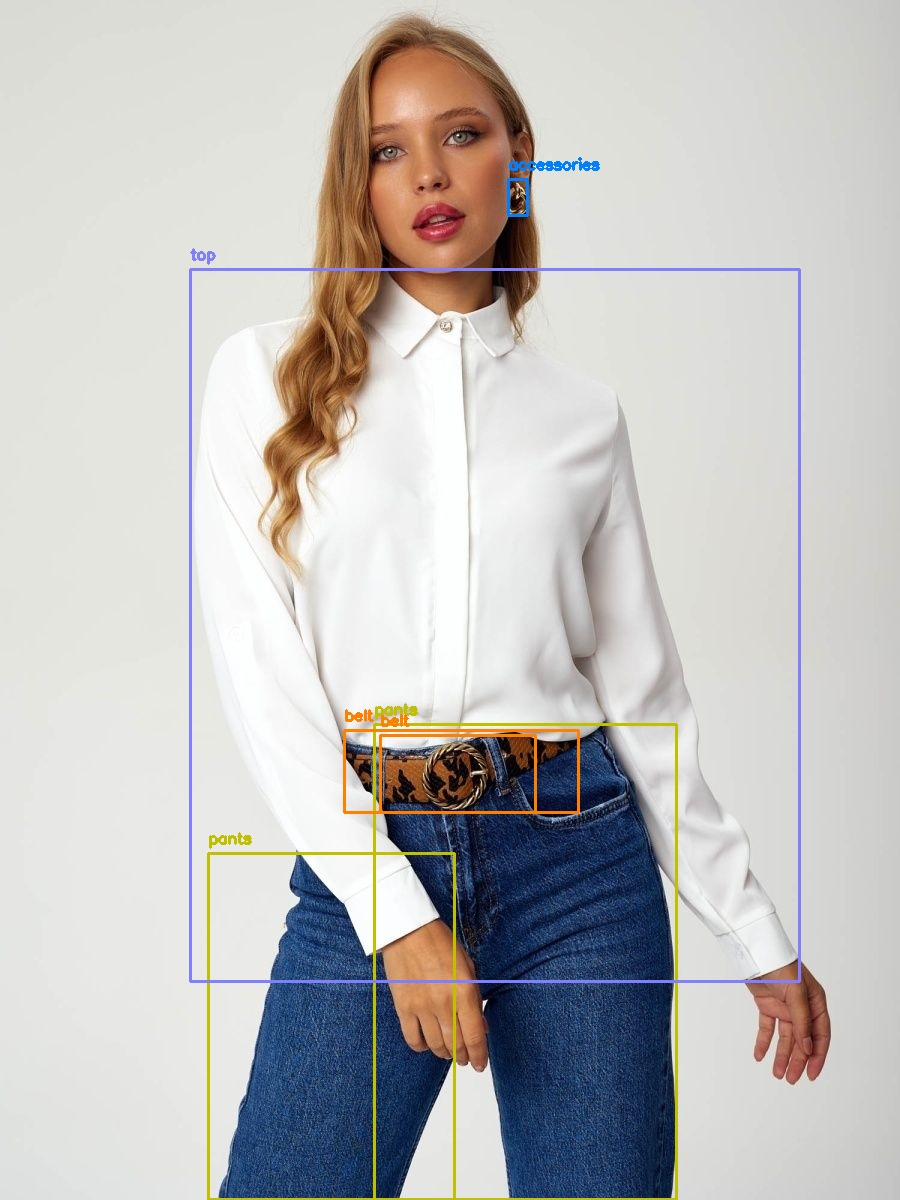

ORIGINAL IMG
Saved image with boundary boxes to ./pred/predImg(4).jpg


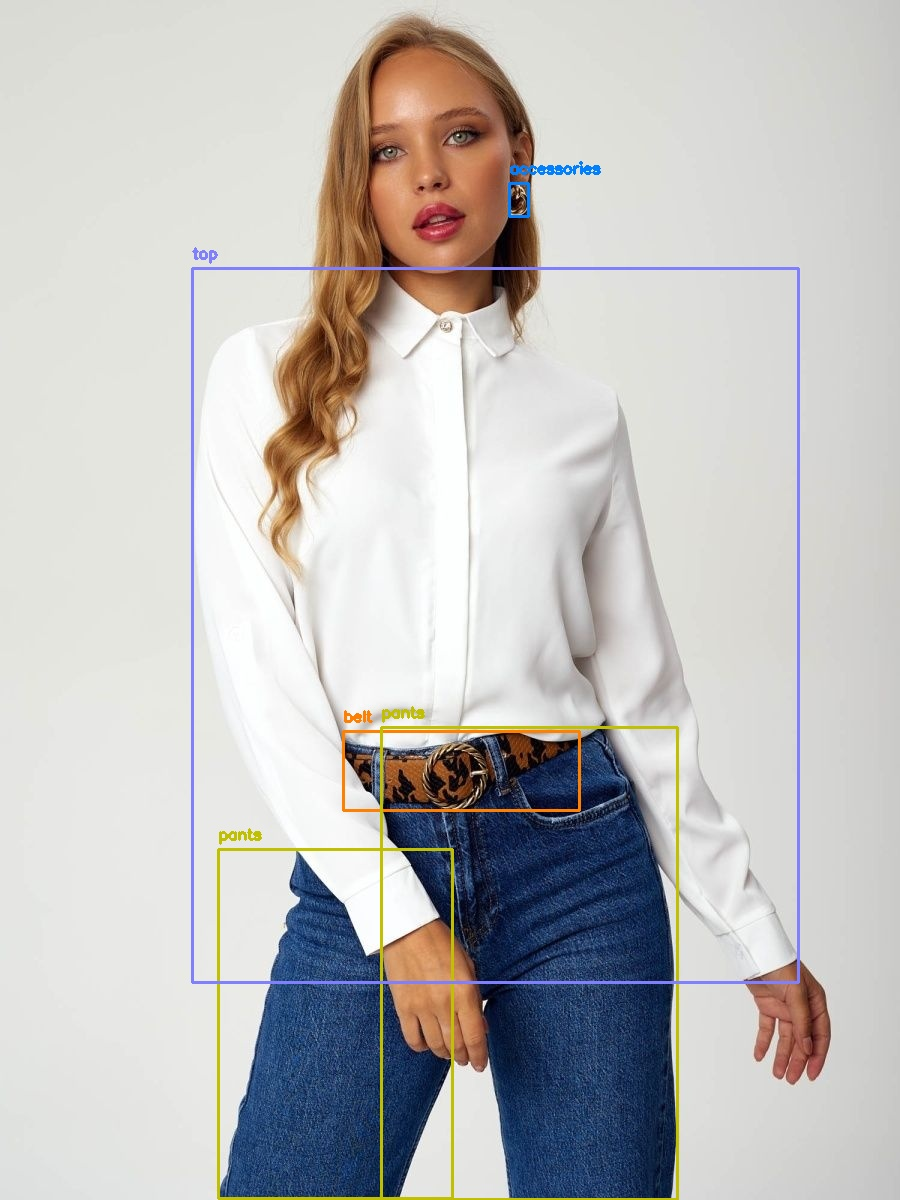

In [ ]:
print("PREDICTET IMG") # Вывод результата предсказания и оригинальной разметки
draw_boundary_boxes("/content/images/"+processedImage, "./pred/labels/"+processedImage[:-4]+"_data.txt",labels) # тестовое изображение
print("ORIGINAL IMG")
draw_boundary_boxes("/content/images/"+processedImage, "/content/labels/"+processedImage[:-4]+".txt",labels) # тестовое изображение



---



## Оценка результата

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # установка кодировки UTF-8 во избежеание ошибок при загрузке файлов

#Скачивание предобученной нами модели
!wget --content-disposition 'https://www.dropbox.com/scl/fi/rchv6ph16yiwhlst853g2/yolov8m-0.865-0.778.pt?rlkey=ncgs124oe4nujn8hnkxiaakby&st=qhc3lii2&dl=0' -O yolov8Pretrained.pt
yoloPretrained = '/content/yolov8Pretrained.pt'

--2024-07-14 17:22:46--  https://www.dropbox.com/scl/fi/rchv6ph16yiwhlst853g2/yolov8m-0.865-0.778.pt?rlkey=ncgs124oe4nujn8hnkxiaakby&st=qhc3lii2&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf9a69d875c61dc56b07f5309d4.dl.dropboxusercontent.com/cd/0/inline/CWsLyC3kcDFDxG52GP67DlV-mIjcnp43b9tolsbCJfFlaband9vP4OgUoZA3Xrt7_1nMikePM0veqG6Av3CkBtBk2BJebB7yC_aEJ3mMDvAzZ7qh0Auw3L42sGkx45mlw2rgP_iWcu2GDZuMdvvVbc0_/file# [following]
--2024-07-14 17:22:47--  https://ucf9a69d875c61dc56b07f5309d4.dl.dropboxusercontent.com/cd/0/inline/CWsLyC3kcDFDxG52GP67DlV-mIjcnp43b9tolsbCJfFlaband9vP4OgUoZA3Xrt7_1nMikePM0veqG6Av3CkBtBk2BJebB7yC_aEJ3mMDvAzZ7qh0Auw3L42sGkx45mlw2rgP_iWcu2GDZuMdvvVbc0_/file
Resolving ucf9a69d875c61dc56b07f5309d4.dl.dropboxusercontent.com (ucf9a69d875c61dc56b07f5309d4.dl.dropboxusercontent.c

In [ ]:
model = YOLO(yoloPretrained)  # load a custom model

# Тестирование модели
metrics = model.val()
map50_90 = metrics.box.map  # map50-95
map50 = metrics.box.map50  # map50
map75 = metrics.box.map75  # map75
print(f"\nmap50:\t\t{map50:.3}\nmap75:\t\t{map75:.3}\nmap50-95:\t{map50_90:.3}")

Ultralytics YOLOv8.2.56 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,847,287 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/datasets/labels/val.cache... 664 images, 0 backgrounds, 0 corrupt: 100%|██████████| 664/664 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


                   all        664       2977      0.907      0.818      0.866      0.778
           accessories        233        507      0.894      0.531      0.661      0.416
                   bag        114        157      0.781      0.732       0.79      0.673
                  belt         55         79      0.836      0.608      0.646      0.509
                 dress         92        152      0.828      0.789      0.842      0.785
               glasses         76         85      0.962      0.835      0.903      0.772
              headwear         91        104      0.971      0.978      0.994       0.96
                 outer        195        361      0.895      0.731      0.814      0.713
                 pants        241        394      0.912      0.789      0.877      0.791
                 scarf         35         41      0.984          1      0.995      0.974
                  shoe        184        393      0.906      0.835       0.89      0.806
                short

In [ ]:
mAPvalues = [map50, map75, map50_90]

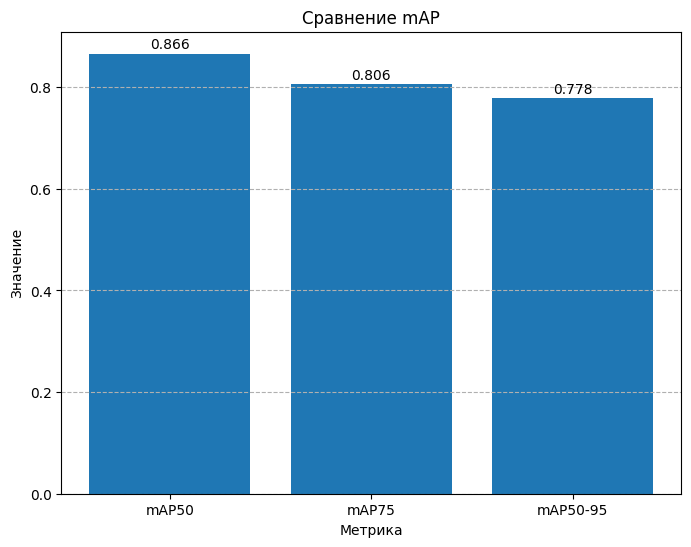

In [ ]:
# @title mAP visualisation
import matplotlib.pyplot as plt
# Данные для диаграммы
metrics = ['mAP50', 'mAP75', 'mAP50-95']
values = mAPvalues

# Создание фигуры и оси
fig, ax = plt.subplots(figsize=(8, 6))

# Построение столбчатой диаграммы
ax.bar(metrics, values)

# Добавление меток к осям и заголовка
ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение mAP')

# Отображение значений над столбцами
for i, v in enumerate(values):
    ax.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)

# Отображение сетки
ax.grid(axis='y', linestyle='--')

# Отображение диаграммы
plt.show()

## Немного мыслей по решению

Выбранная модель YOLOv8m спавляется с обнаружением объектов. Модель показывает высокую точность предсказания и исходя из кривых обучения может быть улучшена при обучении на большем количестве данных и эпох.

Скорость предсказания модели: 19.3ms preprocess, 1715.7ms inference, 27.3ms postprocess per image того 1,762с/изображение

Сама модель достигает такой точности за счёт следующих шагов:


1.   Предобработка данных. Датасет был сбалансирован и очищен от изображений с пустой разметкой
2.   Аугментация данных. Модель аугментирует подающиеся в неё данные добавляя: размытие, изменение размера, обесцвечивыние и высветлене изображения
3. Модель использует оптимизатор AdamW(lr=0.000588, momentum=0.9) и оптимальный batch_size вычисляемый автоматически для использования 70% ОЗУ, таким образом при увеличения вычислительной мощности модель так же может быть обучена лучше
4. Используются гиперпараметры обучения, размеры изображений и каналы RGB привычные для модели. Файл со значениями гиперпараметров подкачивается с официального github разработчиков YOLOv8, изменение размера и цвета изображения происходит при подаче изображения в модель
